In [11]:
import warnings
warnings.filterwarnings('ignore')
import gc

In [12]:
from platform import python_version

print(python_version())

3.6.8


In [13]:
import matplotlib.pylab as plt
import numpy as np
from mgemu import emu, emu_fast


In [14]:
import pyccl
import camb

In [15]:
import math
from scipy.interpolate import interp1d
from scipy.integrate import quad, dblquad
from scipy.special import gamma
from scipy.integrate import odeint
from scipy.integrate import quad_vec



In [72]:
import time

In [18]:
### LCDM parameters
h=0.6774 # See README and the accompanying paper regarding the value of h. 
Om = 0.3089
Omh2=(h**2)*Om
Obh2 = 0.02203
Och2 = Omh2-Obh2
ns=0.9667
s8=0.8159
### Hu-Sawicki model parameters
fr0=1e-5
n=1
### Redshift
z=0
sigmafid=3.0

In [19]:
cosmofid = pyccl.Cosmology(Omega_c=Om-0.02203/(h**2), Omega_b=0.02203/(h**2), h=h, sigma8=s8, n_s=ns, Neff=3.04, transfer_function='boltzmann_class', matter_power_spectrum='emu')








In [20]:
#Setup basic parameters for year10&Y1 LSST photo-z samples
NY10=48*20000*3600
ay10= 0.90
z0y10 = 0.28
biny10 = 0.05
b1y10 = 0.95
#for year1 sample
NY1=18*20000*3600
ay1= 0.94
z0y1 = 0.26
biny1 = 0.1
b1y1 = 1.05

In [21]:
timesteps = np.loadtxt('timestepsCOLA.txt')
irangey10 = np.array([43,45,48,53,57,61,65,70,75,82])
irangey1 = np.array([43,48,57,65,75])
Nt = irangey10[irangey10.shape[0]-1]

Nseed=2000 #25

In [22]:
#Define a-dependent functions for growth factor equation
def Omegatime(a, Om0):
 return Om0/(Om0+(1-Om0)*a*a*a)
#adot
def adot(a, Om0):
 return np.sqrt(Om0/a+(1-Om0)*a*a)
def H(a, Om0):
 return adot(a, Om0)/a
def adotprime(a, Om0):
 return (-Om0/a/a + 2*(1-Om0)*a)/np.sqrt(Om0/a+(1-Om0)*a*a)/2
#Define additional functions needed for
def mfr(a, Om0, fr0, nfr): #scalar field mass
 return (1/2997.72)*math.sqrt(1./(nfr+1)/fr0)*math.sqrt(math.pow(Om0+4*(1-Om0),-nfr-1))*math.sqrt(math.pow(Om0/a/a/a+4*(1-Om0),2+nfr))
def geff(a, Om0, fr0, nfr, k): #g_eff
 return k*k/(k*k+a*a*mfr(a, Om0, fr0, nfr)*mfr(a, Om0, fr0, nfr))/3
#Define 1/adot^3 integrand
def invadot3(a, Om0):
 return 1/adot(a, Om0)/adot(a, Om0)/adot(a, Om0)
#Define 1/adot^3 integral
def intToday(Om0, amin):
 return quad(invadot3,0,amin,args=(Om0))[0]
def Damin(Om0, amin):
 return 2.5*Om0*H(amin, Om0)*intToday(Om0, amin)
def DH1(a, Om0):
 return -3*Om0/(2*a*a*a*math.sqrt((a*a*a+Om0-Om0*a*a*a)/a))
def der0(Om0, amin):
 return 2.5*Om0*(DH1(amin, Om0)*intToday(Om0, amin)+H(amin, Om0)*invadot3(amin, Om0))

In [23]:
#Setup integration to get comoving volume for various z bin
#Comoving distance integrator
def integrand(a, Omm):
 return 1/math.sqrt(a*Omm+a*a*a*a*(1-Omm))
#get comoving volume
def Vcom(z, Omm):
 return (4*math.pi*20000)/(3*41252.96)*math.pow(2997.92458*quad(integrand, 1./(1+z), 1, args=(Omm))[0],3)#*math.pow(10,-9)
#get comoving differential volume in redshift bin with width +-0.05
def Vbin(z, Omm, bin):
 return Vcom(z+bin, Omm)-Vcom(z-bin, Omm)
Veff=np.vectorize(Vbin)

#Define function fro differential dN/dz to be integrated
def dNdz(z, alpha, z0, ntot):
 return (ntot*alpha/(z0*gamma(3.0/alpha)))*(z/z0)*(z/z0)*math.exp(-math.pow(z/z0,alpha))
def Nz(z, alpha, z0, ntot, bin):
 return quad(dNdz, z-bin, z+bin, args=(alpha, z0, ntot))[0]

In [24]:
abserr = 1.0e-13
relerr = 1.0e-13
#Define growth factor differential equation system
def growth(y, a, Om0):
 D, w = y
 dyda = [w, -(adotprime(a, Om0) + 2*H(a, Om0))*w/adot(a, Om0) + 1.5*Omegatime(a, Om0)*H(a, Om0)*H(a, Om0)*D/adot(a, Om0)/adot(a, Om0)]
 return dyda
 
#y0 = [0.0019999999,0.999999999]
arange = np.logspace(math.log(0.002,10),math.log(1,10),1000)
#setting up boundary conditions
y0 = [Damin(Om, arange[0]),der0(Om, arange[0])]
sol = odeint(growth, y0, arange, args=(Om,), atol=abserr, rtol=relerr)
#Spline GR growth factor  solution and growth rate.
Dgr = interp1d(arange, sol[:,0], kind='cubic')
#and also growth rate
fgr = interp1d(arange, arange*sol[:,1]/sol[:,0], kind='cubic')


In [25]:
def growthMG(y, a, Om0, fr0, nfr, k):
 D, w = y
 dyda = [w, -(adotprime(a, Om0) + 2*H(a, Om0))*w/adot(a, Om0) + 1.5*Omegatime(a, Om0)*H(a, Om0)*H(a, Om0)*D*(1+geff(a, Om0, fr0, nfr, k))/adot(a, Om0)/adot(a, Om0)]
 return dyda
#klin, Pklin = np.loadtxt("./plinGRDESIpl_z0.txt", unpack=True)
#kscale=klin
#growthMG=np.vectorize(growthMG)


#DMG = interp2d(arange, kscale, solMG, kind='cubic')
#fgrowthMG = interp2d(arange, kscale, fMG, kind='cubic')

#Defining mygrowth routine to efficiently get D(k,aref) & f(k,aref) for a given time aref
def mygrowthMG(ascale, Om0, fr0, nfr, k):
 arangeint = np.logspace(math.log(0.002,10),math.log(ascale,10),1000)
 soltemp = odeint(growthMG, y0, arangeint, args=(Om,fr0,nfr,k), atol=abserr, rtol=relerr)
 return soltemp[999,0],ascale*soltemp[999,1]/soltemp[999,0]
mygrowthMG = np.vectorize(mygrowthMG)

In [26]:
#Now iterate of different snapshots
for i in (irangey10):
 astep = timesteps[i,0]
 zstep = timesteps[i,1]
 #linear bias for galaxy sample, in our case Y10
 b1=b1y10*Dgr(1)/Dgr(astep) #Bias for Y10
 #b1=b1y1*Dgr(1)/Dgr(astep) #Bias for Y10
 print ('a,z,b_1=',astep, zstep, b1)

a,z,b_1= 0.4512 1.216313 1.7096583337348537
a,z,b_1= 0.4708 1.124045 1.645654696216662
a,z,b_1= 0.5002 0.999201 1.5599659653732123
a,z,b_1= 0.5492 0.820831 1.439767025161971
a,z,b_1= 0.5884 0.699524 1.359885641811489
a,z,b_1= 0.6276 0.593372 1.2915087247085706
a,z,b_1= 0.6668 0.4997 1.232567867300583
a,z,b_1= 0.7158 0.397038 1.169726499808988
a,z,b_1= 0.7648 0.307531 1.1166678302825346
a,z,b_1= 0.8334 0.199904 1.0553364364635174


In [61]:
def pmg(Om, h, ns, s8, fR0, n, z):
    Omh2 = (h**2)*Om
    pkratio, k = emu_fast(Omh2, ns, s8, fR0, n, z)
    gc.collect()
    # cosmo = pyccl.Cosmology(Omega_c= Om, Omega_b=0.0, h=h, n_s=ns, sigma8=s8, transfer_function='bbks')
    cosmo = pyccl.Cosmology(Omega_c=Om-0.02203/(h**2), Omega_b=0.02203/(h**2), h=h, sigma8=s8, n_s=ns, Neff=3.04, transfer_function='boltzmann_class', matter_power_spectrum='emu')
    a = 1./(1+z)
    #Now we have to be careful, because mgemu k-units are in h/Mpc, while CCL units are in 1/Mpc. convert
    kccl = k*h
    pk_nl = pyccl.nonlin_matter_power(cosmo, kccl, a)
    #CCL output pk is in Mpc^3, convert to (Mpc/h)^3
    pk_nl *= h*h*h
    #pk_mg = pk_lcdm*pkratio
    pk_mg = pk_nl*pkratio
    return pk_mg, k

In [62]:
#Defining function to calculate galaxy power spectrum, using the matter Pk from function pmg
#Additional arguments needed are linear bias b1& snot noise term shot
def p_ggmg(Om, h, ns, s8, fR0, n, z, b1, shot):
    Omh2 = (h**2)*Om
    pkratio, k = emu_fast(Omh2, ns, s8, fR0, n, z)
    gc.collect()
    cosmo = pyccl.Cosmology(Omega_c=Om-0.02203/(h**2), Omega_b=0.02203/(h**2), h=h, sigma8=s8, n_s=ns, Neff=3.04, transfer_function='boltzmann_class', matter_power_spectrum='emu')
    a = 1./(1+z)
    #Now we have to be careful, because mgemu k-units are in h/Mpc, while CCL units are in 1/Mpc. convert k-emu range
    kccl = k*h
    pk_nl = pyccl.nonlin_matter_power(cosmo, kccl, a)
    #CCL output pk is in Mpc^3, convert to (Mpc/h)^3
    pk_nl *= h*h*h
    #pk_mg = pk_lcdm*pkratio
    pk_mg = pk_nl*pkratio
    pgg_mg = b1*b1*pk_mg + shot
    return pgg_mg, k

In [63]:
#New function to define anisotropic galaxy P(k) in MG
def p_ggkmu(mu, Om, h, ns, s8, fR0, n, z, b1, shot, sigma):
    Omh2 = (h**2)*Om
    pkratio, k = emu_fast(Omh2, ns, s8, fR0, n, z)
    cosmo = pyccl.Cosmology(Omega_c=Om-0.02203/(h**2), Omega_b=0.02203/(h**2), h=h, sigma8=s8, n_s=ns, Neff=3.04, transfer_function='boltzmann_class', matter_power_spectrum='emu')
    a = 1./(1+z)
    #Now we have to be careful, because mgemu k-units are in h/Mpc, while CCL units are in 1/Mpc. convert k-emu range
    kccl = k*h
    pk_nl = pyccl.nonlin_matter_power(cosmo, kccl, a)
    #CCL output pk is in Mpc^3, convert to (Mpc/h)^3
    pk_nl *= h*h*h
    #pk_mg = pk_lcdm*pkratio
    pk_mg = pk_nl*pkratio
    #Calculate growth rate that is now needed
    #f = pyccl.growth_rate(cosmo, a)
    f = mygrowthMG(a, Om, fR0, n, k)[1]
    #ii = np.where(k==kk)
    #kmode = k[ii]
    kmode = k
    #pgg_mg = (b1+f*mu*mu)*(b1+f*mu*mu)*(pk_mg[ii] + shot)*np.exp(-kmode*kmode*sigma*sigma*mu*mu) 
    #Calculate Alcock factors
    #First, fiducial
    Alf = (pyccl.angular_diameter_distance(cosmofid, a))**2/pyccl.h_over_h0(cosmofid, a)
    #Then for current cosmology
    Al = (pyccl.angular_diameter_distance(cosmo, a))**2/pyccl.h_over_h0(cosmo, a)
    pgg_mg = (Alf/Al)*(b1+f*mu*mu)*(b1+f*mu*mu)*(pk_mg + shot)*np.exp(-kmode*kmode*sigma*sigma*mu*mu) 
    return pgg_mg

In [64]:
p_ggkmu = np.vectorize(p_ggkmu)

In [65]:
def p_ggRSD0(Om, h, ns, s8, fR0, n, z, b1, shot, sigma):
    def p_gfunc(mu):
        return p_ggkmu(mu, Om, h, ns, s8, fR0, n, z, b1, shot, sigma)
    #I = quad(p_ggkmu, 0.0, 1.0, args=(Om, h, ns, s8, fR0, n, z, b1, shot, sigma))[0]
    I = quad_vec(p_gfunc, 0.0, 1.0)[0]
    return I

In [66]:
p_ggRSD0 = np.vectorize(p_ggRSD0)

In [67]:
def p_ggRSD2(Om, h, ns, s8, fR0, n, z, b1, shot, sigma):
    def p_gfunc(mu):
        return (7.5*mu*mu-2.5)*p_ggkmu(mu, Om, h, ns, s8, fR0, n, z, b1, shot, sigma)
    #I = quad(p_ggkmu, 0.0, 1.0, args=(Om, h, ns, s8, fR0, n, z, b1, shot, sigma))[0]
    I = quad_vec(p_gfunc, 0.0, 1.0)[0]
    return I

In [68]:
p_ggRSD2 = np.vectorize(p_ggRSD2)

In [69]:
def p_ggRSD4(Om, h, ns, s8, fR0, n, z, b1, shot, sigma):
    def p_gfunc(mu):
        return ((9.0*35.0/8.)*mu*mu*mu*mu -(9.0*30./8.0)*mu*mu+(9.0*3./8.))*p_ggkmu(mu, Om, h, ns, s8, fR0, n, z, b1, shot, sigma)
    #I = quad(p_ggkmu, 0.0, 1.0, args=(Om, h, ns, s8, fR0, n, z, b1, shot, sigma))[0]
    I = quad_vec(p_gfunc, 0.0, 1.0)[0]
    return I

In [70]:
p_ggRSD4 = np.vectorize(p_ggRSD4)

In [22]:
#Loop to generate RSD monopole covariance matrices at different z
Nseed=2000 #25
sigmafid = 3.0
#for i in range(Nsteps):
#for i in range(Nt,Nt+1):
for i in (irangey10):    
#for i in (irangey1):
 print (i)
 astep = timesteps[i,0]
 zstep = timesteps[i,1]
 #linear bias for galaxy sample, in our case Y10
 b1=b1y10*Dgr(1)/Dgr(astep) #Bias for Y10
 #b1=b1y1*Dgr(1)/Dgr(astep) #Bias for Y10
 print ('a,z,b_1=',astep, zstep, b1)
 #for j in range(Nseed):
 for j in range(Nseed):   
  #if j==1192 or j==1196 or j==1198:
  # continue
  #pklin= np.loadtxt('/home/astrosun2/gvalogiannis/CAMB/test_plindes_'+str(j)+'.txt')locals()["pkLdat_"+str(j)+"_"+str(i)+]
  locals()['pkLseed_'+str(j)+'_'+str(i)] = np.loadtxt('/n/home02/gvalogiannis/Downloads/home/astrosun2/gvalogiannis/colacode/tassev/Pemulator/PLCDMseed2k_'+str(j)+'_'+str(i)+'.txt')
  locals()['pkMGseed_'+str(j)+'_'+str(i)]= np.loadtxt('/n/home02/gvalogiannis/Downloads/home/astrosun2/gvalogiannis/colacode/tassev/Pemulator/PMGseed2k_'+str(j)+'_'+str(i)+'.txt')
  #Import GR and LCDM power spectra for matter
  #locals()['pkLCDMseed_'+str(j)+'_'+str(i)]= locals()['pkLseed_'+str(j)+'_'+str(i)][:,1]
  Ptemp= locals()['pkMGseed_'+str(j)+'_'+str(i)][:,1]
  kvec = locals()['pkMGseed_'+str(j)+'_'+str(i)][:,0]
  #Ptemp = locals()['pkMGseed'+str(j)+'_'+str(i)]
  
  #locals()['pkLCDMseed_'+str(j)+'_'+str(i)] *= b1*b1
  #locals()['pkMGseed'+str(j)+'_'+str(i)] *= b1*b1
  #And then add shot noise contributions
  Ptemp += Veff(zstep, Om, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
  #locals()['pkLCDMseed_'+str(j)+'_'+str(i)] += Veff(zstep, Om, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
  #locals()['pkMGseed'+str(j)+'_'+str(i)] += Veff(zstep, Om, biny1)/Nz(zstep, ay1, z0y1, NY1, biny1)
  #locals()['pkLCDMseed_'+str(j)+'_'+str(i)] += Veff(zstep, Om, biny1)/Nz(zstep, ay1, z0y1, NY1, biny1)
  #Calculate growth rate that is now needed
  f = pyccl.growth_rate(cosmofid, astep)
  def p_gfunctemp(mu):
    return (b1+f*mu*mu)*(b1+f*mu*mu)*Ptemp*np.exp(-kvec*kvec*sigmafid*sigmafid*mu*mu) 

  locals()['pkMGseed'+str(j)+'_'+str(i)] = quad_vec(p_gfunctemp, 0.0, 1.0)[0]


 #locals()['ratioMGtoGRseed_'+str(i)]= locals()['ratioMGseed0_'+str(i)]
 locals()['pkMGcov_'+str(i)]= locals()['pkMGseed0_'+str(i)]
 #locals()['PkGR_'+str(i)]= locals()['pkLCDMseed_0_'+str(i)]
 for jj in range(1,Nseed):
  #locals()['PkGR_'+str(i)]=np.vstack((locals()['PkGR_'+str(i)],locals()['pkLCDMseed_'+str(jj)+'_'+str(i)]))
  locals()['pkMGcov_'+str(i)]=np.vstack((locals()['pkMGcov_'+str(i)],locals()['pkMGseed'+str(jj)+'_'+str(i)]))
  
 locals()['covPMGmatRSDY10_'+str(i)]=np.cov(np.transpose(locals()['pkMGcov_'+str(i)]))
 locals()['pkMGavgRSDY10_'+str(i)]=np.mean(locals()['pkMGcov_'+str(i)], axis=0)
 np.savetxt('PggY10RSD_step_'+str(i)+'.txt', np.array((locals()['pkMGseed_0_'+str(i)][:,0],locals()['pkMGavgRSDY10_'+str(i)])).T, fmt = '%1.8f')
 #np.savetxt('PggY1_step_'+str(i)+'.txt', np.array((locals()['pkMGseed_0_'+str(i)][:,0],locals()['pkMGavg_'+str(i)])).T, fmt = '%1.8f')
 np.savetxt('covarianceY10RSD_step_'+str(i)+'.txt', locals()['covPMGmatRSDY10_'+str(i)], fmt = '%1.8f')
 #np.savetxt('covarianceY1_step_'+str(i)+'.txt', locals()['covPMGmat_'+str(i)], fmt = '%1.8f')

43
a,z,b_1= 0.4512 1.216313 1.7096583337348537
45
a,z,b_1= 0.4708 1.124045 1.645654696216662
48
a,z,b_1= 0.5002 0.999201 1.5599659653732123
53
a,z,b_1= 0.5492 0.820831 1.439767025161971
57
a,z,b_1= 0.5884 0.699524 1.359885641811489
61
a,z,b_1= 0.6276 0.593372 1.2915087247085706
65
a,z,b_1= 0.6668 0.4997 1.232567867300583
70
a,z,b_1= 0.7158 0.397038 1.169726499808988
75
a,z,b_1= 0.7648 0.307531 1.1166678302825346
82
a,z,b_1= 0.8334 0.199904 1.0553364364635174


In [39]:
#Loop to generate RSD monopole covariance matrices at different z
Nseed=2000 #25
sigmafid = 3.0
#for i in range(Nsteps):
#for i in range(Nt,Nt+1):
for i in (irangey1):    
#for i in (irangey1):
 print (i)
 astep = timesteps[i,0]
 zstep = timesteps[i,1]
 #linear bias for galaxy sample, in our case y1
 b1=b1y1*Dgr(1)/Dgr(astep) #Bias for y1
 #b1=b1y1*Dgr(1)/Dgr(astep) #Bias for y1
 print ('a,z,b_1=',astep, zstep, b1)
 #for j in range(Nseed):
 for j in range(Nseed):   
  #if j==1192 or j==1196 or j==1198:
  # continue
  #pklin= np.loadtxt('/home/astrosun2/gvalogiannis/CAMB/test_plindes_'+str(j)+'.txt')locals()["pkLdat_"+str(j)+"_"+str(i)+]
  locals()['pkLseed_'+str(j)+'_'+str(i)] = np.loadtxt('/n/home02/gvalogiannis/Downloads/home/astrosun2/gvalogiannis/colacode/tassev/Pemulator/PLCDMseed2k_'+str(j)+'_'+str(i)+'.txt')
  locals()['pkMGseed_'+str(j)+'_'+str(i)]= np.loadtxt('/n/home02/gvalogiannis/Downloads/home/astrosun2/gvalogiannis/colacode/tassev/Pemulator/PMGseed2k_'+str(j)+'_'+str(i)+'.txt')
  #Import GR and LCDM power spectra for matter
  #locals()['pkLCDMseed_'+str(j)+'_'+str(i)]= locals()['pkLseed_'+str(j)+'_'+str(i)][:,1]
  Ptemp= locals()['pkMGseed_'+str(j)+'_'+str(i)][:,1]
  kvec = locals()['pkMGseed_'+str(j)+'_'+str(i)][:,0]
  #Ptemp = locals()['pkMGseed'+str(j)+'_'+str(i)]
  
  #locals()['pkLCDMseed_'+str(j)+'_'+str(i)] *= b1*b1
  #locals()['pkMGseed'+str(j)+'_'+str(i)] *= b1*b1
  #And then add shot noise contributions
  Ptemp += Veff(zstep, Om, biny1)/Nz(zstep, ay1, z0y1, NY1, biny1)
  #locals()['pkLCDMseed_'+str(j)+'_'+str(i)] += Veff(zstep, Om, biny1)/Nz(zstep, ay1, z0y1, Ny1, biny1)
  #locals()['pkMGseed'+str(j)+'_'+str(i)] += Veff(zstep, Om, biny1)/Nz(zstep, ay1, z0y1, NY1, biny1)
  #locals()['pkLCDMseed_'+str(j)+'_'+str(i)] += Veff(zstep, Om, biny1)/Nz(zstep, ay1, z0y1, NY1, biny1)
  #Calculate growth rate that is now needed
  f = pyccl.growth_rate(cosmofid, astep)
  def p_gfunctemp(mu):
    return (b1+f*mu*mu)*(b1+f*mu*mu)*Ptemp*np.exp(-kvec*kvec*sigmafid*sigmafid*mu*mu) 

  locals()['pkMGseed'+str(j)+'_'+str(i)] = quad_vec(p_gfunctemp, 0.0, 1.0)[0]


 #locals()['ratioMGtoGRseed_'+str(i)]= locals()['ratioMGseed0_'+str(i)]
 locals()['pkMGcov_'+str(i)]= locals()['pkMGseed0_'+str(i)]
 #locals()['PkGR_'+str(i)]= locals()['pkLCDMseed_0_'+str(i)]
 for jj in range(1,Nseed):
  #locals()['PkGR_'+str(i)]=np.vstack((locals()['PkGR_'+str(i)],locals()['pkLCDMseed_'+str(jj)+'_'+str(i)]))
  locals()['pkMGcov_'+str(i)]=np.vstack((locals()['pkMGcov_'+str(i)],locals()['pkMGseed'+str(jj)+'_'+str(i)]))
  
 locals()['covPMGmatRSDY1_'+str(i)]=np.cov(np.transpose(locals()['pkMGcov_'+str(i)]))
 locals()['pkMGavgRSDY1_'+str(i)]=np.mean(locals()['pkMGcov_'+str(i)], axis=0)
 np.savetxt('Pggy1RSD_step_'+str(i)+'.txt', np.array((locals()['pkMGseed_0_'+str(i)][:,0],locals()['pkMGavgRSDY1_'+str(i)])).T, fmt = '%1.8f')
 #np.savetxt('PggY1_step_'+str(i)+'.txt', np.array((locals()['pkMGseed_0_'+str(i)][:,0],locals()['pkMGavg_'+str(i)])).T, fmt = '%1.8f')
 np.savetxt('covarianceY1RSD_step_'+str(i)+'.txt', locals()['covPMGmatRSDY1_'+str(i)], fmt = '%1.8f')
 #np.savetxt('covarianceY1_step_'+str(i)+'.txt', locals()['covPMGmat_'+str(i)], fmt = '%1.8f')

43
a,z,b_1= 0.4512 1.216313 1.8896223688648384
48
a,z,b_1= 0.5002 0.999201 1.7241729090967084
57
a,z,b_1= 0.5884 0.699524 1.5030314988442777
65
a,z,b_1= 0.6668 0.4997 1.3623118533322236
75
a,z,b_1= 0.7648 0.307531 1.2342118124175385


In [47]:
#In case we just want to load the covariance RSD data 

for i in (irangey10):
 print (i)
 astep = timesteps[i,0]
 zstep = timesteps[i,1]
 locals()['covPMGmatRSDY10_'+str(i)] = np.loadtxt('/n/home02/gvalogiannis/mgemu/notebooks/covarianceY10RSD_step_'+str(i)+'.txt')

for i in (irangey1):
 print (i)
 astep = timesteps[i,0]
 zstep = timesteps[i,1]
 locals()['covPMGmatRSDY1_'+str(i)] = np.loadtxt('/n/home02/gvalogiannis/mgemu/notebooks/covarianceY1RSD_step_'+str(i)+'.txt')

43
45
48
53
57
61
65
70
75
82
43
48
57
65
75


In [40]:
#timesteps

In [63]:
#k

In [41]:
#rL

In [43]:
#rMG/rL

In [ ]:
#p_ggRSD0(Om=Om, h=h, ns=ns, s8=s8, fR0=fr0, n=1, z=0.1, b1=1, shot=0, sigma=3.0, kk=k[k<=0.3])/pp0[k<=0.3]

In [35]:
ff = pyccl.growth_rate(cosmo, 1.0)

In [36]:
1**2+ 2*ff/3 + (ff**2)/5

1.359999913968606

In [8]:
np.random.randint(1e5, size=1)

array([21774])

In [44]:
pkratio , k = emu_fast(Omh2=Omh2, ns=ns, s8=s8, fR0=fr0, n=n, z=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


In [26]:
h=0.67 # See README and the accompanying paper regarding the value of h.
Omh2=(h**2)*0.281
ns=0.971
s8=0.82
### Hu-Sawicki model parameters
fr0=1e-5
n=1
### Redshift
z=0.3

In [27]:
import time

In [11]:

import time



### LCDM parameters
h=0.67 # See README and the accompanying paper regarding the value of h.
Omh2=(h**2)*0.281
ns=0.971
s8=0.82
### Hu-Sawicki model parameters
fr0=1e-5
n=1
### Redshift
z=0.3

n_trials = 20

start_time = time.time()
for _ in range(n_trials):
    emu(Omh2=Omh2, ns=ns, s8=s8, fR0=fr0, n=n, z=z)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
for _ in range(n_trials):
    emu_fast(Omh2=Omh2, ns=ns, s8=s8, fR0=fr0, n=n, z=z)
print("--- %s seconds ---" % (time.time() - start_time))


print( 'difference: ' + str( np.max(np.abs( emu(Omh2=Omh2, ns=ns, s8=s8, fR0=fr0, n=n, z=z)[0] - emu_fast(Omh2=Omh2, ns=ns, s8=s8, fR0=fr0, n=n, z=z)[0] ))))

--- 134.42922711372375 seconds ---
--- 4.309811592102051 seconds ---
difference: 0.0


In [48]:
pkratiofast , k = emu_fast(Omh2=Omh2, ns=ns, s8=s8, fR0=fr0, n=n, z=0.1)

In [41]:
#pkratio/pkratiofast

In [49]:
# cosmo = pyccl.Cosmology(Omega_c= Om, Omega_b=0.0, h=h, n_s=ns, sigma8=s8, transfer_function='bbks')
cosmo = pyccl.Cosmology(Omega_c=0.26-0.0453, Omega_b=0.0453, h=0.72, sigma8=0.80, n_s=0.96, Neff=3.04, transfer_function='boltzmann_class', matter_power_spectrum='emu')
#pyccl.comoving_radial_distance(cosmo, 1./(1+z))
a = 1./(1+z)
pk_lcdm = pyccl.nonlin_matter_power(cosmo, k*h, a)
pk_lcdm *= h*h*h

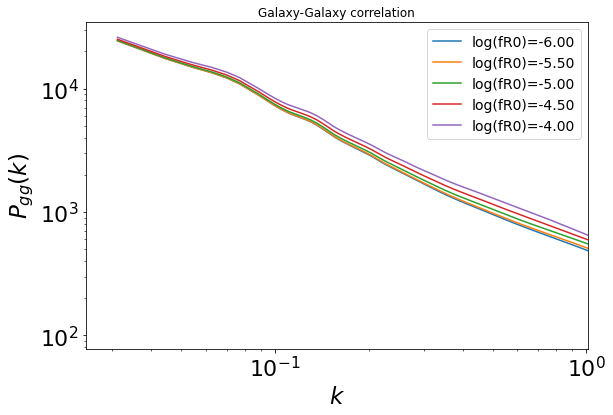

In [60]:
import matplotlib.pylab as plt
import numpy as np

plt.figure(1, figsize=(9, 6) )
plt.tick_params(axis='both', which='major', labelsize=22)
fR0_arr= np.logspace(-6, -4, 5)
b1 =1.2
shot = 10.0
for i in range(5):
    fR0 = fR0_arr[i]
    #p_mg, k = pmg(Om, h, ns, s8, fR0, n, z)
    p_gg, k = p_ggmg(Om, h, ns, s8, fR0, n, 0.1, b1, shot)
    #plt.plot(k, p_mg, label = "log(fR0)={:.2f}".format(np.log10(fR0)) )
    plt.plot(k, p_gg, label = "log(fR0)={:.2f}".format(np.log10(fR0)) )
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$P_{gg}(k)$', fontsize=23)
plt.xlabel(r'$k$', fontsize=23)
plt.legend(fontsize=14)
plt.title('Galaxy-Galaxy correlation')
plt.xlim(0, 1.01)
#plt.ylim(1e3,)


plt.show()

In [23]:
#Now that we can evalute the galaxy Pk for a given MG cosmology, let's build functions to actually predict the galaxy bias and shot noise for a realistic LSST sample 

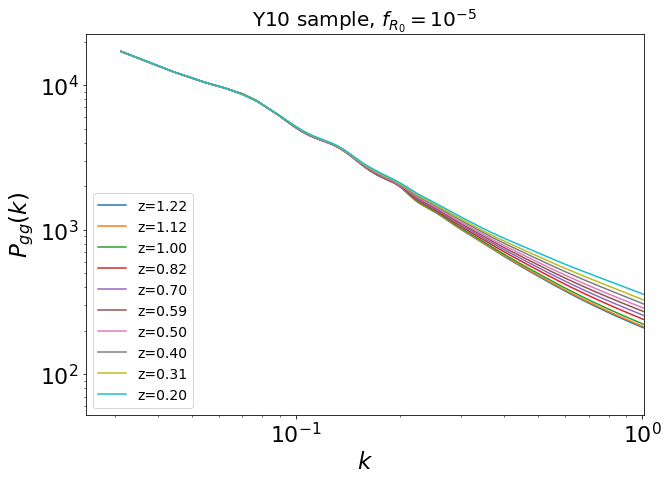

In [41]:
#Evaluate and Plot P_gg for 10 snapshots of the Y10 galaxy sample
plt.figure(1, figsize=(10, 7) )
plt.tick_params(axis='both', which='major', labelsize=22)
fR0_arr= np.logspace(-6, -4, 5)
#b1 =1.2
#shot = 10.0
for i in (irangey10):
    astep = timesteps[i,0]
    zstep = timesteps[i,1]
    #linear bias for galaxy sample, in our case Y10
    b1=b1y10*Dgr(1)/Dgr(astep) #Bias for Y10
    Shot = Veff(zstep, Om, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
    p_gg, k = p_ggmg(Om, h, ns, s8, fr0, n, zstep, b1, Shot)
    #plt.plot(k, p_mg, label = "log(fR0)={:.2f}".format(np.log10(fR0)) )
    plt.plot(k, p_gg, label = "z={:.2f}".format(zstep) )
plt.xscale('log')
plt.yscale('log')
#plt.ylabel(r'$V_{eff}(k)$', fontsize=23)
plt.ylabel(r'$P_{gg}(k)$', fontsize=23)
plt.xlabel(r'$k$', fontsize=23)
plt.legend(fontsize=14)
plt.title(r'Y10 sample, $f_{R_0}=10^{-5}$', fontsize=20)
plt.xlim(0, 1.01)
#plt.ylim(1e3,)


plt.show()

In [30]:
#np.full(k.shape[0],5)

In [71]:
ff0 = pyccl.growth_rate(cosmo, 1.0)

In [72]:
ff = pyccl.growth_rate(cosmo, 0.5)

In [73]:
ff/ff0

1.7893239695995564

In [68]:
1**2+ 2*ff/3/ff0 + ((ff/ff0)**2)/5

2.833218700036407

In [31]:
sigmafid = 3.0

43
45
48
53
57
61
65
70
75
82


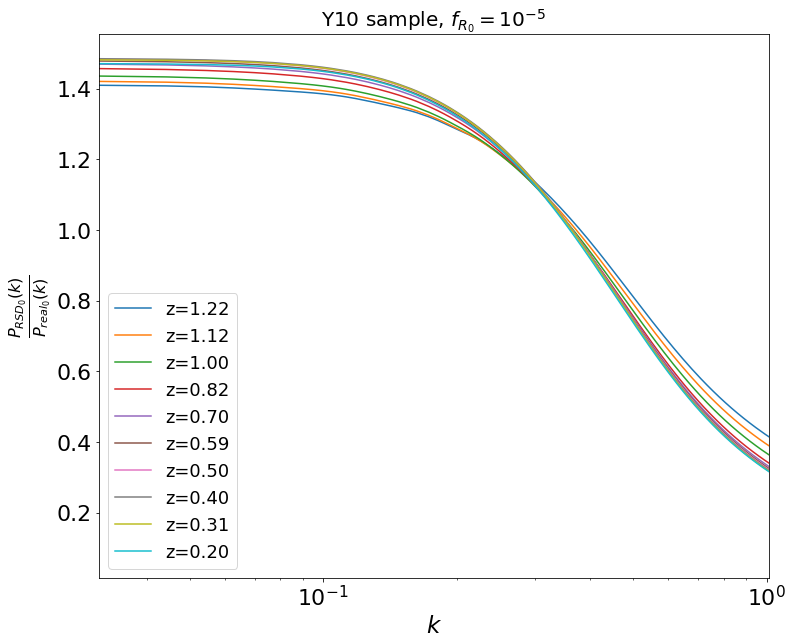

In [32]:
#Evaluate and Plot P_gg for 10 snapshots of the Y10 galaxy sample
plt.figure(1, figsize=(12, 10) )
plt.tick_params(axis='both', which='major', labelsize=22)
fR0_arr= np.logspace(-6, -4, 5)
#b1 =1.2
#shot = 10.0
for i in (irangey10[:]):
    print (i)
    astep = timesteps[i,0]
    zstep = timesteps[i,1]
    #linear bias for galaxy sample, in our case Y10
    b1=b1y10*Dgr(1)/Dgr(astep) #Bias for Y10
    Shot = Veff(zstep, Om, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
    p_gg, k = p_ggmg(Om, h, ns, s8, fr0, n, zstep, b1, Shot)
    p_RSD0 =  p_ggRSD0(Om, h, ns, s8, fr0, n, zstep, b1, Shot, sigmafid)
    #p_ggRSD0(Om, h, ns, s8, fR0, n, z, b1, shot, sigma)
    #plt.plot(k, p_mg, label = "log(fR0)={:.2f}".format(np.log10(fR0)) )
    #plt.plot(k, p_gg, label = "z={:.2f}".format(zstep) )
    plt.plot(k, p_RSD0/p_gg, label = "z={:.2f}".format(zstep) )
    #ff = pyccl.growth_rate(cosmo, astep)
    #plt.plot(k, np.full(k.shape[0],1**2+ 2*ff/3 + (ff**2)/5), linestyle='--')
plt.xscale('log')
#plt.yscale('log')
#plt.ylabel(r'$V_{eff}(k)$', fontsize=23)
plt.ylabel(r'$\frac{P_{RSD_0}(k)}{P_{real_0}(k)}$', fontsize=23)
plt.xlabel(r'$k$', fontsize=23)
plt.legend(fontsize=18, loc="best")
plt.title(r'Y10 sample, $f_{R_0}=10^{-5}$', fontsize=20)
plt.xlim(k[0], 1.01)
#plt.ylim(1e3,)


plt.show()

82


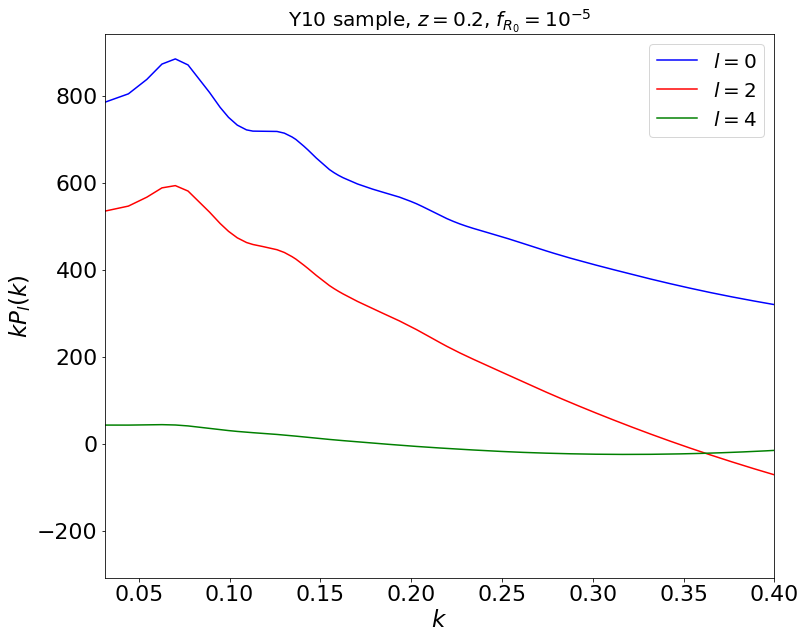

In [34]:
#Evaluate and Plot P_gg for 10 snapshots of the Y10 galaxy sample
plt.figure('ells', figsize=(12, 10) )
plt.tick_params(axis='both', which='major', labelsize=22)
fR0_arr= np.logspace(-6, -4, 5)
#b1 =1.2
#shot = 10.0
for i in (irangey10[-1:]):
    print (i)
    astep = timesteps[i,0]
    zstep = timesteps[i,1]
    #linear bias for galaxy sample, in our case Y10
    b1=b1y10*Dgr(1)/Dgr(astep) #Bias for Y10
    Shot = Veff(zstep, Om, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
    p_gg, k = p_ggmg(Om, h, ns, s8, fr0, n, zstep, b1, Shot)
    p_RSD0 =  p_ggRSD0(Om, h, ns, s8, fr0, n, zstep, b1, Shot, sigmafid)
    p_RSD2 =  p_ggRSD2(Om, h, ns, s8, fr0, n, zstep, b1, Shot, sigmafid)
    p_RSD4 =  p_ggRSD4(Om, h, ns, s8, fr0, n, zstep, b1, Shot, sigmafid)
    #p_ggRSD0(Om, h, ns, s8, fR0, n, z, b1, shot, sigma)
    #plt.plot(k, p_mg, label = "log(fR0)={:.2f}".format(np.log10(fR0)) )
    #plt.plot(k, p_gg, label = "z={:.2f}".format(zstep) )
    plt.plot(k, k*p_RSD0, label = r'$l=0$', color='b')
    plt.plot(k, k*p_RSD2, label = r'$l=2$', color='r')
    plt.plot(k, k*p_RSD4, label = r'$l=4$', color='g')
    #ff = pyccl.growth_rate(cosmo, astep)
    #plt.plot(k, np.full(k.shape[0],1**2+ 2*ff/3 + (ff**2)/5), linestyle='--')
#plt.xscale('log')
#plt.yscale('log')
#plt.ylabel(r'$V_{eff}(k)$', fontsize=23)
plt.ylabel(r'$k P_{l}(k)$', fontsize=23)
plt.xlabel(r'$k$', fontsize=23)
plt.legend(loc="best", fontsize=20)
plt.title(r'Y10 sample, $z=0.2$, $f_{R_0}=10^{-5}$', fontsize=20)
plt.xlim(k[0], 0.4)
#plt.ylim(1e3,)


plt.show()

In [103]:
for k in (irangey10[2:-1]):
#for k in range(0):
#for k in (irangey10[-1:]):
    astep = timesteps[k,0]
    zstep = timesteps[k,1]
    print (k, zstep)

48 0.999201
53 0.820831
57 0.699524
61 0.593372
65 0.4997
70 0.397038
75 0.307531


1e-06
3.162277660168379e-06
1e-05
3.1622776601683795e-05
0.0001


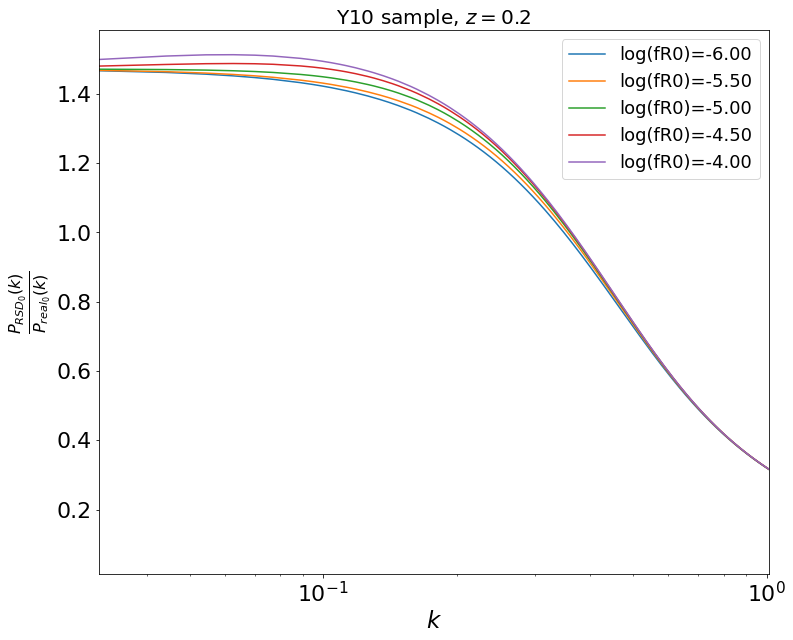

In [33]:
#Evaluate and Plot P_gg for 10 snapshots of the Y10 galaxy sample
plt.figure(1, figsize=(12, 10) )
plt.tick_params(axis='both', which='major', labelsize=22)
fR0_arr= np.logspace(-6, -4, 5)
#b1 =1.2
#shot = 10.0
for fr in (fR0_arr):
    print (fr)
    astep = timesteps[82,0]
    zstep = timesteps[82,1]
    
    #linear bias for galaxy sample, in our case Y10
    b1=b1y10*Dgr(1)/Dgr(astep) #Bias for Y10
    Shot = Veff(zstep, Om, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
    p_gg, k = p_ggmg(Om, h, ns, s8, fr, n, zstep, b1, Shot)
    p_RSD0 =  p_ggRSD0(Om, h, ns, s8, fr, n, zstep, b1, Shot, sigmafid)
    #p_ggRSD0(Om, h, ns, s8, fR0, n, z, b1, shot, sigma)
    #plt.plot(k, p_mg, label = "log(fR0)={:.2f}".format(np.log10(fR0)) )
    #plt.plot(k, p_gg, label = "z={:.2f}".format(zstep) )
    #print (p_RSD0/p_gg)
    plt.plot(k, p_RSD0/p_gg, label = "log(fR0)={:.2f}".format(np.log10(fr)) )
    #ff = pyccl.growth_rate(cosmo, astep)
    #plt.plot(k, np.full(k.shape[0],1**2+ 2*ff/3 + (ff**2)/5), linestyle='--')
plt.xscale('log')
#plt.yscale('log')
#plt.ylabel(r'$V_{eff}(k)$', fontsize=23)
plt.ylabel(r'$\frac{P_{RSD_0}(k)}{P_{real_0}(k)}$', fontsize=23)
plt.xlabel(r'$k$', fontsize=23)
plt.legend(fontsize=18, loc="best")
plt.title(r'Y10 sample, $z=0.2$', fontsize=20)
plt.xlim(k[0], 1.01)
#plt.ylim(1e3,)


plt.show()

In [29]:
#print (Nseed, k.shape[0],((Nseed-k.shape[0]-2)/(Nseed-1)))
#Import covariance matrices
for i in (irangey10):
    astep = timesteps[i,0]
    zstep = timesteps[i,1]
    locals()['covPMGmat_'+str(i)] = np.loadtxt('./Covariance_data/covariance_step_'+str(i)+'.txt')
    locals()['InvcovPMGmat_'+str(i)] = ((Nseed-k.shape[0]-2)/(Nseed-1))*np.linalg.inv(locals()['covPMGmat_'+str(i)])
    

In [30]:
for i in (irangey10):
    astep = timesteps[i,0]
    zstep = timesteps[i,1]
    print (zstep)

1.216313
1.124045
0.999201
0.820831
0.699524
0.593372
0.4997
0.397038
0.307531
0.199904


In [57]:
kvec = k
def applyPlotStyle14():
 plt.tick_params(axis='both',which='major',length=5, left='on', right='on', width=1, direction='inout')
 plt.tick_params(axis='both',which='minor',length=3.2,left='on', right='on', width=1, direction='inout')
 plt.tick_params(which='both',width=1.3)
 plt.grid(True)
 #plt.xscale("log")
 #plt.yscale("log")
 plt.xlim(kvec[0], 0.49)
 plt.ylim(kvec[0], 0.49)
 #plt.ylabel(r"$\frac{P_{MG}}{P_{\Lambda CDM}}$",fontsize=18)
 plt.xlabel(r"$k (h/Mpc)$",fontsize=20)
 plt.ylabel(r"$k (h/Mpc)$",fontsize=20)
 #plt.ylabel(r"$r (Mpc/h)$",fontsize=18)
 plt.legend(loc="best", frameon=False, numpoints=1, prop={'size':12})

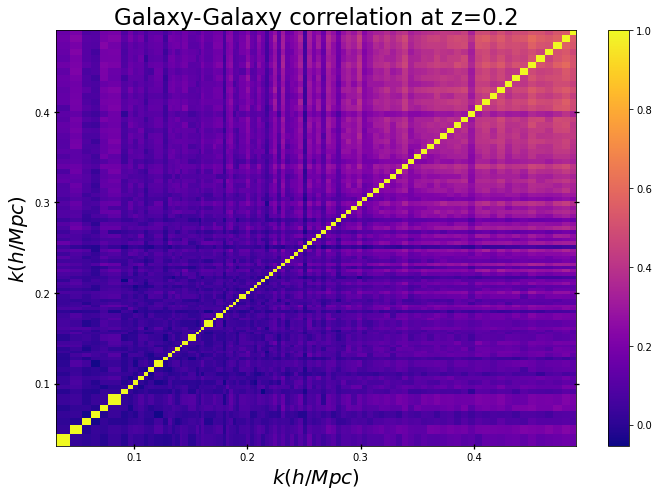

In [58]:
#Get correlation matrix for step=43
covxx = np.sqrt(np.diag(covPMGmat_82))*np.identity(len(kvec))
invcoxx = np.linalg.inv(covxx)
corrPMGmat_82 = np.dot(invcoxx,np.dot(covPMGmat_82,invcoxx))
import scipy.ndimage as scim
#sigma_x = sigma_y = 2.0
#sigma = [sigma_y, sigma_x]
#cov_mat2 = scim.filters.gaussian_filter(covPMGmat_82, sigma, mode='wrap')
#covxxsmopth = np.sqrt(np.diag(cov_mat2))*np.identity(len(kvec))
#invcov_mat2 = np.linalg.inv(covxxsmopth)
#corr_mat2 = np.dot(invcov_mat2,np.dot(cov_mat2,invcov_mat2))
ii = np.where(kvec<0.5)
from matplotlib import gridspec
from matplotlib import cm
fig11=plt.figure('test', figsize=(10, 7) )
ax=fig11.add_subplot(111)
applyPlotStyle14()
ax.set_title('Galaxy-Galaxy correlation at z=0.2', fontsize=23)
#pltcov=ax.pcolormesh(kvec,kvec,covPMGmat_82, cmap='plasma')
pltcov=ax.pcolormesh(kvec[ii],kvec[ii],corrPMGmat_82[0: np.array(ii)[0][-1] + 1, 0: np.array(ii)[0][-1] + 1], cmap='plasma')
#pltcov=ax.pcolormesh(kvec,kvec,corr_mat2, cmap='plasma')
#pltcov=ax.pcolormesh(kvec,kvec,cov_mat2, cmap='plasma')
fig11.colorbar(pltcov, ax=ax)
plt.tight_layout()
plt.show()

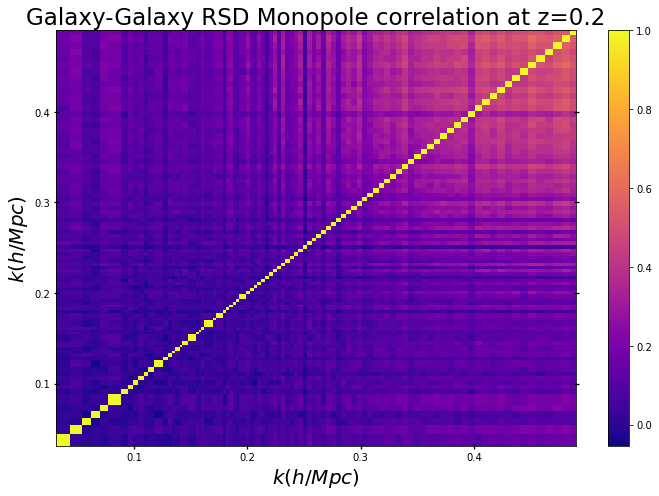

In [59]:
#Get correlation matrix for step=82
covxxRSDY10 = np.sqrt(np.diag(covPMGmatRSDY10_82))*np.identity(len(kvec))
invcoxxRSDY10 = np.linalg.inv(covxxRSDY10)
corrPMGmatRSDY10_82 = np.dot(invcoxxRSDY10,np.dot(covPMGmatRSDY10_82,invcoxxRSDY10))
import scipy.ndimage as scim
#sigma_x = sigma_y = 2.0
#sigma = [sigma_y, sigma_x]
#cov_mat2 = scim.filters.gaussian_filter(covPMGmat_82, sigma, mode='wrap')
#covxxsmopth = np.sqrt(np.diag(cov_mat2))*np.identity(len(kvec))
#invcov_mat2 = np.linalg.inv(covxxsmopth)
#corr_mat2 = np.dot(invcov_mat2,np.dot(cov_mat2,invcov_mat2))
ii = np.where(kvec<0.5)
from matplotlib import gridspec
from matplotlib import cm
fig11=plt.figure('test', figsize=(10, 7) )
ax=fig11.add_subplot(111)
applyPlotStyle14()
ax.set_title('Galaxy-Galaxy RSD Monopole correlation at z=0.2', fontsize=23)
#pltcov=ax.pcolormesh(kvec,kvec,covPMGmat_82, cmap='plasma')
pltcov=ax.pcolormesh(kvec[ii],kvec[ii],corrPMGmatRSDY10_82[0: np.array(ii)[0][-1] + 1, 0: np.array(ii)[0][-1] + 1], cmap='plasma')
#pltcov=ax.pcolormesh(kvec,kvec,corr_mat2, cmap='plasma')
#pltcov=ax.pcolormesh(kvec,kvec,cov_mat2, cmap='plasma')
fig11.colorbar(pltcov, ax=ax)
plt.tight_layout()
plt.show()

In [53]:
#(corrPMGmatRSDY10_82/corrPMGmat_82)

In [22]:
ii

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101]),)

In [31]:
npar = 6 #no of paramaters to constrain
FY10tot = np.zeros([npar,npar])
FY1tot = np.zeros([npar,npar])
imax =  47 #135 #maximum k scale array index
#imax = 21

In [25]:
#Setup integration to get Fisher matrix using Tegmark's analytical formula
#Integrand
#def integrandFisher(kk, derD1, derD2, D, kvec):
 #construct splines of vectors, to make integrator happy
# der1int = interp1d(kvec, derD1, kind='cubic')
# der2int = interp1d(kvec, derD2, kind='cubic')
# Pfidint = interp1d(kvec, D, kind='cubic')    
# return kk*kk*der1int(kk)*der2int(kk)/Pfidint(kk)/Pfidint(kk)
#integrandFisher = np.vectorize(integrandFisher)
#Quadrature
#def Fisher_gaussian(derD1, derD2, D, kvec, imax):
# return quad(integrandFisher, kvec[0], kvec[imax], args=(derD1, derD2, D, kvec))[0]#*math.pow(10,-9)
#Fisher_gaussian = np.vectorize(Fisher_gaussian)
print (kvec[0:imax])

[0.0312147  0.0442523  0.054388   0.06273525 0.07010365 0.0771044
 0.08893805 0.0947648  0.099384   0.10422835 0.10930885 0.1128327
 0.11833265 0.1260851  0.1301498  0.1343455  0.1364938  0.14089405
 0.14314705 0.14776175 0.15496425 0.15744225 0.1599599  0.1625178
 0.1704396  0.17316505 0.1787475  0.1816058  0.18450985 0.18746035
 0.190458   0.1935036  0.19974165 0.2029357  0.20618085 0.2094779
 0.21282765 0.21623095 0.21968865 0.22320165 0.22677085 0.23039715
 0.23408145 0.2378246  0.2416276  0.24549145 0.2494171 ]


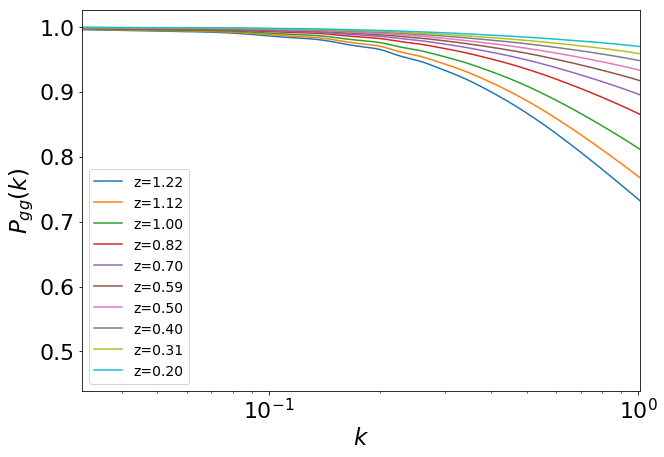

In [36]:
plt.figure(1, figsize=(10, 7) )
plt.tick_params(axis='both', which='major', labelsize=22)
fR0_arr= np.logspace(-6, -4, 5)
#b1 =1.2
#shot = 10.0
for i in (irangey10):
    astep = timesteps[i,0]
    zstep = timesteps[i,1]
    #linear bias for galaxy sample, in our case Y10
    b1=b1y10*Dgr(1)/Dgr(astep) #Bias for Y10
    Shot = Veff(zstep, Om, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
    Pfid, kkk = p_ggmg(Om, h, ns, s8, fr0, n, zstep, b1, Shot)
    nlit = 1.0/Shot
    plt.plot(kkk, (nlit*Pfid)*(nlit*Pfid)/(1.0+nlit*Pfid)/(1.0+nlit*Pfid), label = "z={:.2f}".format(zstep) )
plt.xscale('log')
#plt.yscale('log')
plt.ylabel(r'$P_{gg}(k)$', fontsize=23)
plt.xlabel(r'$k$', fontsize=23)
plt.legend(fontsize=14)
plt.xlim(0, 1.01)
#plt.ylim(1e3,)


plt.show()

In [46]:
#Calculating derivatives for Y10 sample

#Omstep = 0.003
#s8step = 0.05 #0.05
#nsstep = 0.03 #0.025
#fr0step = fr0*0.1
#nstep = 0.1*n
#b1step=0.01
Omstep = 0.003
s8step = 0.05 #0.05
nsstep = 0.03 #0.025
fr0step = fr0*0.1
nstep = 0.1*n
b1step=0.01
#for i in range(82,83):
#for i in (irangey10):
for i in (irangey10[5:10]):    
    astep = timesteps[i,0]
    zstep = timesteps[i,1]
    #linear bias for galaxy sample, in our case Y10
    b1=b1y10*Dgr(1)/Dgr(astep) #Bias for Y10
    Shot = Veff(zstep, Om, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
    ndens = 1.0/Shot
    Pfid, kkk = p_ggmg(Om, h, ns, s8, fr0, n, zstep, b1, Shot)
    Pfidint = interp1d(kkk, Pfid, kind='cubic')
    Vol = Veff(zstep, Om, biny10)
    #Start with Omh2 derivatives
    Omh2up = Omh2 + Omstep
    Omh2down = Omh2 - Omstep
    Omup = Omh2up/h/h
    Omdown = Omh2down/h/h
    #Now we need to be careful. When Om changes, growth factor and Volume change, -> bias&shot noise change
    y0up = [Damin(Omup, arange[0]),der0(Omup, arange[0])]
    solup = odeint(growth, y0up, arange, args=(Omup,), atol=abserr, rtol=relerr)
    #Spline GR growth factor  solution and growth rate.
    Dgrup = interp1d(arange, solup[:,0], kind='cubic')
    b1up=b1y10*Dgrup(1)/Dgrup(astep)
    Shotup = Veff(zstep, Omup, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
    p_ggup, k = p_ggmg(Omup, h, ns, s8, fr0, n, zstep, b1up, Shotup)
    #Do same for down
    y0down = [Damin(Omdown, arange[0]),der0(Omdown, arange[0])]
    soldown = odeint(growth, y0down, arange, args=(Omdown,), atol=abserr, rtol=relerr)
    #Spline GR growth factor  solution and growth rate.
    Dgrdown = interp1d(arange, soldown[:,0], kind='cubic')
    b1down=b1y10*Dgrdown(1)/Dgrdown(astep)
    Shotdown = Veff(zstep, Omdown, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
    p_ggdown, k = p_ggmg(Omdown, h, ns, s8, fr0, n, zstep, b1down, Shotdown)
    #And evaluate derivative
    derOmh = (p_ggup-p_ggdown)/2/Omstep
    #dertot array for all derivatives to be stacked
    dertot = derOmh
    #print (derOmh)
    #Now move on to sigma_8
    s8up = s8 + s8step
    p_ggup, k = p_ggmg(Om, h, ns, s8up, fr0, n, zstep, b1, Shot)
    s8down = s8 - s8step
    p_ggdown, k = p_ggmg(Om, h, ns, s8down, fr0, n, zstep, b1, Shot)
    #derivative
    ders8 = (p_ggup-p_ggdown)/2/s8step
    dertot = np.vstack((dertot,ders8))
    #print (dertot.shape)
    #Now move on to n_s
    nsup = ns + nsstep
    p_ggup, k = p_ggmg(Om, h, nsup, s8, fr0, n, zstep, b1, Shot)
    nsdown = ns - nsstep
    p_ggdown, k = p_ggmg(Om, h, nsdown, s8, fr0, n, zstep, b1, Shot)
    derns = (p_ggup-p_ggdown)/2/nsstep
    dertot = np.vstack((dertot,derns))
    #print (dertot.shape)  
    #Now move on to fr0
    fr0up = fr0 + fr0step
    p_ggup, k = p_ggmg(Om, h, ns, s8, fr0up, n, zstep, b1, Shot)
    fr0down = fr0 - fr0step
    p_ggdown, k = p_ggmg(Om, h, ns, s8, fr0down, n, zstep, b1, Shot)
    derfr = fr0*(p_ggup-p_ggdown)/2/fr0step
    dertot = np.vstack((dertot,derfr)) 
    #print (dertot.shape)
    #Now move on to n
    nup = n + nstep
    p_ggup, k = p_ggmg(Om, h, ns, s8, fr0, nup, zstep, b1, Shot)
    ndown = n - nstep
    p_ggdown, k = p_ggmg(Om, h, ns, s8, fr0, ndown, zstep, b1, Shot)
    dern = (p_ggup-p_ggdown)/2/nstep
    dertot = np.vstack((dertot,dern)) 
    #print (dertot.shape)
    #Finally, do nuissance parameter b_1
    b1up = b1 + b1step
    p_ggup, k = p_ggmg(Om, h, ns, s8, fr0, n, zstep, b1up, Shot)
    b1down = b1 - b1step
    p_ggdown, k = p_ggmg(Om, h, ns, s8, fr0, n, zstep, b1down, Shot)
    derb = (p_ggup-p_ggdown)/2/b1step
    dertot = np.vstack((dertot,derb))    
    #print (dertot.shape)
    #print (dertot)
    #Now that all the derivatives have been evaluated, it's time to import the covariance matrix for given z-snapshot
    #covPMGmatz = np.loadtxt('./Covariance_data/covariance_step_'+str(i)+'.txt')
    #import scipy.ndimage as scim
    #sigma_x = sigma_y = 2.0
    #sigma = [sigma_y, sigma_x]
    #cov_matsmooth = scim.filters.gaussian_filter(covPMGmatz, sigma, mode='wrap')
    #InvcovPMGmatz = ((Nseed-kvec.shape[0]-2)/(Nseed-1))*np.linalg.inv(covPMGmatz)[0:imax,0:imax]
    #InvcovPMGmatz = ((Nseed-kvec.shape[0]-2)/(Nseed-1))*np.linalg.inv(cov_matsmooth)[0:imax,0:imax]
    #Diagonal approximation, temporary test
    #covPMGmatz = np.diag(covPMGmat_82)*np.identity(len(kvec))
    #InvcovPMGmatz = np.linalg.inv(covPMGmatz[0:imax,0:imax])
    dertot = dertot.T 
    #loop over all parameters to populate it    
    for ii in range(npar):
      for jj in range(npar):
        #FY10tot[ii,jj] += np.dot(dertot[0:imax,ii],np.dot(InvcovPMGmatz,dertot[0:imax,jj]))
        #Analytical approximation
        der1int = interp1d(kvec, dertot[:,ii], kind='cubic')
        der2int = interp1d(kvec, dertot[:,jj], kind='cubic')         
        def integrandFisher(kk):
         #construct splines of vectors, to make integrator happy 
         Vk = (ndens*Pfidint(kk))*(ndens*Pfidint(kk))/(1.0 + ndens*Pfidint(kk))/(1.0 + ndens*Pfidint(kk))
         return kk*kk*der1int(kk)*der2int(kk)*Vk/Pfidint(kk)/Pfidint(kk)
        integrandFisher = np.vectorize(integrandFisher) 
        def Fisher_gaussian(imax):
         return quad(integrandFisher, kvec[0], kvec[imax])[0]#*math.pow(10,-9)
        Fisher_gaussian = np.vectorize(Fisher_gaussian)
        FY10tot[ii,jj] += Vol*Fisher_gaussian(imax)/4/math.pi/math.pi

In [47]:
#FY10tot

In [49]:
#FY10tot
np.savetxt('./Covariance_data/FisherzY10analhalfzk025.txt', FY10tot)

In [ ]:
#dertot = dertot.T
#print (dertot[:,0].shape)
#print (dertot)
#FisheTest = np.dot(dertot[:,3],np.dot(InvcovPMGmat_43,dertot[:,3]))
#print (k[0:60])
print (np.sqrt(np.linalg.inv(FY10tot)[3,3]))
#print (np.linalg.inv(FY10tot)[3,3])
#covPMGmatztest = np.loadtxt('./Covariance_data/covariance_step_43.txt')
#Inv1 = np.linalg.inv(covPMGmatztest[0:imax,0:imax])
#Inv2 = np.linalg.inv(covPMGmatztest)[0:imax,0:imax]
#print (Inv1/Inv2)
#print (((Nseed-k.shape[0]-2)/(Nseed-1))/((Nseed-60-2)/(Nseed-1)))
#print ((Nseed-imax-2)/(Nseed-1))

In [ ]:
fig = plt.figure('dertest')
print (zstep)
fr0up = fr0 + fr0step
#p_ggup, k = p_ggmg(Om, h, ns, s8, fr0up, n, zstep, b1, Shot)
fr0down = fr0 - fr0step
#p_ggdown, k = p_ggmg(Om, h, ns, s8, fr0down, n, zstep, b1, Shot)
#plt.loglog(k, p_ggup, color='r')
#plt.loglog(k, p_ggdown, color='r')
plt.semilogx(k,dertot[:,4])
plt.semilogx(k,dertot[:,4])
plt.show()

In [ ]:
fig = plt.figure('frtest')
#zstep = 
fr0stepint = fr0*0.01
fr0up = fr0 + fr0stepint
#p_ggup, k = p_ggmg(Om, h, ns, s8, fr0up, n, zstep, b1, Shot)
fr0down = fr0 - fr0stepint
#p_ggdown, k = p_ggmg(Om, h, ns, s8, fr0down, n, zstep, b1, Shot)
astep = 1./(1+zstep)
pk_lcdm = pyccl.nonlin_matter_power(cosmo, k*h, astep)
pk_lcdm *= h*h*h
#plt.loglog(k, p_ggup, color='r')
#plt.loglog(k, p_ggdown, color='b')
#plt.semilogx(k,fr0*(p_ggup-p_ggdown)/(fr0stepint*2))
#plt.semilogx(k,(p_ggup/p_ggdown))
plt.semilogx(k,(p_ggdown/pk_lcdm))
#plt.semilogx(k,dertot[:,3])
plt.show()

In [ ]:
np.savetxt('./Covariance_data/FisherzY10smoothk03.txt', FY10tot)

In [ ]:
#Repeating previous calculation for Y1 sample
Omstep = 0.003
s8step = 0.05 #0.05
nsstep = 0.03 #0.025
fr0step = fr0*0.1
nstep = 0.1*n
b1step=0.01
#for i in range(43,44):
for i in (irangey1):
    astep = timesteps[i,0]
    zstep = timesteps[i,1]
    #linear bias for galaxy sample, in our case Y1
    b1=b1y1*Dgr(1)/Dgr(astep) #Bias for Y1
    Shot = Veff(zstep, Om, biny1)/Nz(zstep, ay1, z0y1, NY1, biny1)
    Pfid, kkk = p_ggmg(Om, h, ns, s8, fr0, n, zstep, b1, Shot)
    Pfidint = interp1d(kkk, Pfid, kind='cubic')
    Vol = Veff(zstep, Om, biny1)
    #Start with Omh2 derivatives
    Omh2up = Omh2 + Omstep
    Omh2down = Omh2 - Omstep
    Omup = Omh2up/h/h
    Omdown = Omh2down/h/h
    #Now we need to be careful. When Om changes, growth factor and Volume change, -> bias&shot noise change
    y0up = [Damin(Omup, arange[0]),der0(Omup, arange[0])]
    solup = odeint(growth, y0up, arange, args=(Omup,), atol=abserr, rtol=relerr)
    #Spline GR growth factor  solution and growth rate.
    Dgrup = interp1d(arange, solup[:,0], kind='cubic')
    b1up=b1y1*Dgrup(1)/Dgrup(astep)
    Shotup = Veff(zstep, Omup, biny1)/Nz(zstep, ay1, z0y1, NY1, biny1)
    p_ggup, k = p_ggmg(Omup, h, ns, s8, fr0, n, zstep, b1up, Shotup)
    #Do same for down
    y0down = [Damin(Omdown, arange[0]),der0(Omdown, arange[0])]
    soldown = odeint(growth, y0down, arange, args=(Omdown,), atol=abserr, rtol=relerr)
    #Spline GR growth factor  solution and growth rate.
    Dgrdown = interp1d(arange, soldown[:,0], kind='cubic')
    b1down=b1y1*Dgrdown(1)/Dgrdown(astep)
    Shotdown = Veff(zstep, Omdown, biny1)/Nz(zstep, ay1, z0y1, NY1, biny1)
    p_ggdown, k = p_ggmg(Omdown, h, ns, s8, fr0, n, zstep, b1down, Shotdown)
    #And evaluate derivative
    derOmh = (p_ggup-p_ggdown)/2/Omstep
    #dertot array for all derivatives to be stacked
    dertot = derOmh
    #print (derOmh)
    #Now move on to sigma_8
    s8up = s8 + s8step
    p_ggup, k = p_ggmg(Om, h, ns, s8up, fr0, n, zstep, b1, Shot)
    s8down = s8 - s8step
    p_ggdown, k = p_ggmg(Om, h, ns, s8down, fr0, n, zstep, b1, Shot)
    #derivative
    ders8 = (p_ggup-p_ggdown)/2/s8step
    dertot = np.vstack((dertot,ders8))
    #print (dertot.shape)
    #Now move on to n_s
    nsup = ns + nsstep
    p_ggup, k = p_ggmg(Om, h, nsup, s8, fr0, n, zstep, b1, Shot)
    nsdown = ns - nsstep
    p_ggdown, k = p_ggmg(Om, h, nsdown, s8, fr0, n, zstep, b1, Shot)
    derns = (p_ggup-p_ggdown)/2/nsstep
    dertot = np.vstack((dertot,derns))
    #print (dertot.shape)  
    #Now move on to fr0
    fr0up = fr0 + fr0step
    p_ggup, k = p_ggmg(Om, h, ns, s8, fr0up, n, zstep, b1, Shot)
    fr0down = fr0 - fr0step
    p_ggdown, k = p_ggmg(Om, h, ns, s8, fr0down, n, zstep, b1, Shot)
    derfr = fr0*(p_ggup-p_ggdown)/2/fr0step
    dertot = np.vstack((dertot,derfr)) 
    #print (dertot.shape)
    #Now move on to n
    nup = n + nstep
    p_ggup, k = p_ggmg(Om, h, ns, s8, fr0, nup, zstep, b1, Shot)
    ndown = n - nstep
    p_ggdown, k = p_ggmg(Om, h, ns, s8, fr0, ndown, zstep, b1, Shot)
    dern = (p_ggup-p_ggdown)/2/nstep
    dertot = np.vstack((dertot,dern)) 
    #print (dertot.shape)
    #Finally, do nuissance parameter b_1
    b1up = b1 + b1step
    p_ggup, k = p_ggmg(Om, h, ns, s8, fr0, n, zstep, b1up, Shot)
    b1down = b1 - b1step
    p_ggdown, k = p_ggmg(Om, h, ns, s8, fr0, n, zstep, b1down, Shot)
    derb = (p_ggup-p_ggdown)/2/b1step
    dertot = np.vstack((dertot,derb))    
    #print (dertot.shape)
    #print (dertot)
    #Now that all the derivatives have been evaluated, it's time to import the covariance matrix for given z-snapshot
    #covPMGmatz = np.loadtxt('./Covariance_data/covarianceY1_step_'+str(i)+'.txt')
    #InvcovPMGmatz = ((Nseed-k.shape[0]-2)/(Nseed-1))*np.linalg.inv(covPMGmatz)[0:imax,0:imax]
    dertot = dertot.T
    for ii in range(npar):
      for jj in range(npar):
        #FY10tot[ii,jj] += np.dot(dertot[0:imax,ii],np.dot(InvcovPMGmatz,dertot[0:imax,jj]))
        #Analytical approximation
        der1int = interp1d(kvec, dertot[:,ii], kind='cubic')
        der2int = interp1d(kvec, dertot[:,jj], kind='cubic')         
        def integrandFisher(kk):
         #construct splines of vectors, to make integrator happy   
         return kk*kk*der1int(kk)*der2int(kk)/Pfidint(kk)/Pfidint(kk)
        integrandFisher = np.vectorize(integrandFisher) 
        def Fisher_gaussian(imax):
         return quad(integrandFisher, kvec[0], kvec[imax])[0]#*math.pow(10,-9)
        Fisher_gaussian = np.vectorize(Fisher_gaussian)
        FY1tot[ii,jj] += Vol*Fisher_gaussian(imax)/4/math.pi/math.pi

In [ ]:
np.savetxt('./Covariance_data/FisherzY1analk03.txt', FY1tot)

In [ ]:
print (FY1tot)

In [27]:
h_l = 0.67
Om_l = 0.3000
Omb_l = 0.0260
s8_l = 0.8200
ns_l=0.9600
print (Om_l-Omb_l)
#a = 1./(1+z)
#Now we have to be careful, because mgemu k-units are in h/Mpc, while CCL units are in 1/Mpc. convert
#kccl = k*h
#pk_nl = pyccl.nonlin_matter_power(cosmo, kccl, a)


0.27399999999999997


In [29]:
kl, Pk97 = np.loadtxt('/Users/gev866/Downloads/Pk_97.txt', unpack=True)
kl, Pk71 = np.loadtxt('/Users/gev866/Downloads/Pk_71.txt', unpack=True)
kl, Pk36 = np.loadtxt('/Users/gev866/Downloads/Pk_36.txt', unpack=True)
#print (kl, Pk97)
a97=1.0/(1.0+0.019)
#cosmo_l = pyccl.Cosmology(Omega_c=Om_l-Omb_l, Omega_b=Omb_l, h=h_l, sigma8=s8_l, n_s=ns_l, Neff=3.04, transfer_function='boltzmann_class', matter_power_spectrum='emu')
#pk_emu = pyccl.nonlin_matter_power(cosmo, kl, a97)

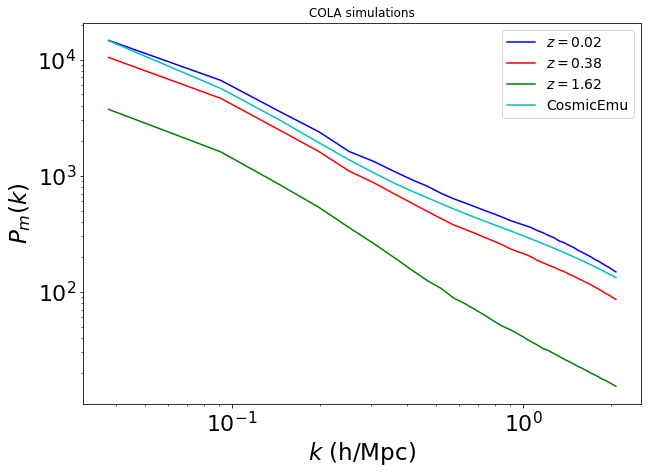

In [39]:
plt.figure('testing', figsize=(10, 7) )
plt.tick_params(axis='both', which='major', labelsize=22)
plt.title('COLA simulations')
plt.plot(kl/h_l, Pk97, label = r'$z=0.02$', color='b')
plt.plot(kl/h_l, Pk71, label = r'$z=0.38$', color='r')
plt.plot(kl/h_l, Pk36, label = r'$z=1.62$', color='g')
plt.plot(kl/h_l, pk_emu*h_l*h_l*h_l, label = 'CosmicEmu', color='c')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$P_{m}(k)$', fontsize=23)
plt.xlabel(r'$k$ (h/Mpc)', fontsize=23)
plt.legend(fontsize=14)
#plt.xlim(0.035, 3.5)
#plt.ylim(1e3,)
plt.show()


In [31]:
nn=1

In [32]:
cov_mat= np.loadtxt('./Covariance_data/covariance_97_2000s.txt')
#sigma_x = sigma_y = 2.0
#sigma = [sigma_y, sigma_x]
#cov_mat = scim.filters.gaussian_filter(cov_matuns, sigma, mode='wrap')
#kz, pkratioz = np.loadtxt('./Covariance_data/ratioavg_97_2000s.txt', unpack=True)
pkratioz, kz = emu_fast(Omh2=Omh2, ns=ns, s8=s8, fR0=fr0, n=nn, z=0.0)# 

TypeError: 'GPR' object is not iterable

In [46]:
l, Cl = np.loadtxt('/Users/gev866/Downloads/Cl_test.txt', unpack=True)
l, Clavg10, Cerr10 = np.loadtxt('/Users/gev866/Downloads/Cl_avg5000.txt', unpack=True)
l, Cl10k, Cerr10k = np.loadtxt('/Users/gev866/Downloads/Cl_avg10000_new.txt', unpack=True)
l, Clavg, Cerr = np.loadtxt('/Users/gev866/Downloads/Cl_avg512new.txt', unpack=True)
l, Clavgold, Cerrold = np.loadtxt('/Users/gev866/Downloads/Cl_avg512.txt', unpack=True)
lzolt, ClZolt, CerrZolt = np.loadtxt('/Users/gev866/Downloads/Cl_avgZolt.txt', unpack=True)
lzolt2, ClZolt2, CerrZolt2 = np.loadtxt('/Users/gev866/Downloads/Cl_avgZolt_2.txt', unpack=True)
lzoltseed, ClZoltseed2, CerrZoltseed2 = np.loadtxt('/Users/gev866/Downloads/Cl_avgZolt_newseed.txt', unpack=True)
l, ClavgG, CerrG = np.loadtxt('/Users/gev866/Downloads/Cl_avg512Gadget_seed2.txt', unpack=True)
l, ClavgG1800, CerrG1800 = np.loadtxt('/Users/gev866/Downloads/Cl_avg512Gadget1800.txt', unpack=True)
#print (Clavg,l)

In [47]:
100*((ClavgG1800/l/(l+1))/(ClZolt/l/(l+1))-1)


array([  7.46569512,   1.94960252,  -1.433629  ,  -1.52990537,
        -1.38716748,  -1.55861364,  -3.18530798,  -2.31316382,
        -0.2198474 ,  -2.28140091,  -2.39805028,  -2.97149723,
        -2.45528918,  -3.44317639,  -4.88508376,  -5.16311299,
        -5.8643206 ,  -6.94614864,  -8.01407051,  -8.06948435,
        -7.79769882,  -7.35366482,  -8.80691455,  -8.495779  ,
        -9.23096282,  -9.19813422,  -9.59059703, -10.47201096,
       -10.09267851, -10.94824423, -12.1448082 , -11.60315218,
       -11.88553374])

In [48]:
z97 = timesteps[97,1]

In [49]:
#pkratioz, kz = emu(Omh2=Omh2, ns=ns, s8=s8, fR0=fr0, n=n, z=0.2)
print (math.pow(10,math.log(fr0,10)))

1e-05


In [50]:
kcondt = np.where(kz < 3.5)
print (cov_mat[0: np.array(kcondt)[0][-1] + 1, 0: np.array(kcondt)[0][-1] + 1].shape)

NameError: name 'kz' is not defined

In [60]:
from matplotlib import gridspec
from matplotlib import cm

In [61]:

import time

In [62]:
#New part to test Nesar's Fisher code
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.misc import derivative




def plot_contours(hessian, pos,  nstd=1., ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  
  def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = - hessian

  cov = np.linalg.pinv(mat)

  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  vals, vecs = eigsorted(cov)
  theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * np.sqrt(vals)
  ellip = Ellipse(xy=pos, width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(0)
  s2 = 1.5*nstd*sigma_marg(1)
  ax.set_xlim(pos[0] - s1, pos[0] + s1)
  ax.set_ylim(pos[1] - s2, pos[1] + s2)
  plt.draw()
  return ellip


def lnlike_k(theta, x, y, kcut):
    p1, p2, p3, p4, p5 = theta
    kcond = np.where(x < kcut)
    new_params = np.array([p1, p2, p3, p4, p5])

    cov_mat_red = cov_mat[0: np.array(kcond)[0][-1] + 1, 0: np.array(kcond)[0][-1] + 1]
    icov_red = np.linalg.inv(cov_mat_red)

    debias_factor = (2000.0 - x.shape[0] - 2)/(2000 - 1)
    icov_red = debias_factor * icov_red

    #model = Emu(new_params) ## using emulator predition 
    model, kdum = emu_fast(Omh2=p1, ns=p2, s8=p3, fR0=math.pow(10,p4), n=p5, z=0.0) ## using emulator predition  
    gc.collect()


    x_red = x[kcond]
    y_red = y[kcond]

    
    model_red = model[kcond]
    x_red = x[kcond]
    y_red = y[kcond]
    
    y_model = np.asarray(y_red-model_red)

    loglike = -0.5*(y_model.dot(icov_red).dot(y_model))
    return loglike


dtheta = 5e-3

def partial_derivative(func, var=0, point=[]):
    args = point[:]
    def wraps(x):
        args[var] = x
        return func(*args)
    return derivative(wraps, point[var], dx = dtheta)


def hess_k(ind0, ind1, klim):

    def loglike(p, q):
        params = np.empty_like(fid_params)
        params[:] = fid_params
        params[ind0] = p
        params[ind1] = q

        return lnlike_k(params, kz, pkratioz, klim)

    def Dx(p, q):
        return partial_derivative(func=loglike, var = 0, point=[p, q])

    def Dy(p, q):
        return partial_derivative(func=loglike, var = 1, point=[p, q])

    def Dxy(p, q):
        return partial_derivative(func=Dy, var = 0, point=[p, q])

    def Dyx(p, q):
        return partial_derivative(func=Dx, var = 1, point=[p, q])  

    def Dxx(p, q):
        return partial_derivative(func=Dx, var = 0, point=[p, q]) 

    def Dyy(p, q):
        return partial_derivative(func=Dy, var = 1, point=[p, q]) 


    h = np.zeros(shape = (2,2))
    h[0, 0] = Dxx(fid_params[ind0], fid_params[ind1])
    h[1, 1] = Dyy(fid_params[ind0], fid_params[ind1])
    h[1, 0] = Dyx(fid_params[ind0], fid_params[ind1])
    h[0, 1] = Dxy(fid_params[ind0], fid_params[ind1])
    print(h)
    return h

def params_ell(ind0, ind1):
    params = np.array([fid_params[ind0], fid_params[ind1]])
    return params




In [63]:
gsc=gridspec.GridSpec(5,5, wspace=0.0, hspace=0.0)
fid_params = np.array([Omh2,ns,s8,math.log(fr0,10),nn])
print (fid_params)
num_parameters = 5

NameError: name 'nn' is not defined

In [37]:


#fig, a = plt.subplots((num_parameters, num_parameters))
f, a = plt.subplots(num_parameters, num_parameters, figsize=(18, 18), sharex = 'col', sharey = 'row')
plt.subplots_adjust(wspace=0.0, hspace=0.0)
Fisherfin = np.zeros(shape = (num_parameters,num_parameters))
for i in range(num_parameters):
    for j in range(num_parameters):
        print(i, j)
        if (i > j):
            sub = hess_k(j,i, 0.25)
            Fisherfin[j,j] = sub[0,0]
            Fisherfin[i,i] = sub[1,1]
            Fisherfin[j,i] = sub[0,1]
            Fisherfin[i,j] = sub[1,0]
            #plot_contours(sub, params_ell(j, i), fill=False, color = 'b', linewidth = 0.1)
            plot_contours(sub, params_ell(j, i), fill=True, ax = a[i, j], alpha=0.3, linewidth = 0.1)
            #plot_contours(hess_k(j,i, 0.15), params_ell(j, i), fill=True, ax = a[i, j], linewidth = 0.1)
            
plt.show()            

0 0
0 1
0 2
0 3
0 4
1 0


NameError: name 'kz' is not defined

In [ ]:
FisherfinT = np.zeros(shape = (num_parameters,num_parameters))
start = time.time()
for i in range(num_parameters):
    for j in range(num_parameters):
        print(i, j)
        if (i > j):
            sub = hess_k(j,i, 0.25)
            FisherfinT[i,i] = sub[0,0]
            FisherfinT[j,j] = sub[1,1]
            FisherfinT[i,j] = sub[0,1]
            FisherfinT[j,i] = sub[1,0]
elapsed_time_fl = (time.time() - start)
print (elapsed_time_fl)

In [ ]:
#np.savetxt('./Covariance_data/FisherHessz97.txt', -Fisherfin)
np.savetxt('./Covariance_data/FisherHessz97Smooth.txt', -Fisherfin)

In [ ]:
np.savetxt('./Covariance_data/FisherHessz97T.txt', -FisherfinT)

In [ ]:
print (np.diag(np.linalg.pinv(-Fisherfin[0:5,0:5])))

In [ ]:
print (np.diag(np.linalg.pinv(-Fisherfin)))

In [ ]:
#import sys
#!{sys.executable} -m pip install camb --user
#!{sys.executable} -m pip install git+https://github.com/lgarrison/asdf.git abacusutils --user

In [64]:
def lnlike_kgal(theta, x, y, kcut, zz, Cov, shot):
    p1, p2, p3, p4, p5, p6 = theta
    kcond = np.where(x < kcut)
    new_params = np.array([p1, p2, p3, p4, p5, p6])

    cov_mat_red = Cov[0: np.array(kcond)[0][-1] + 1, 0: np.array(kcond)[0][-1] + 1]
    icov_red = np.linalg.inv(cov_mat_red)

    debias_factor = (2000.0 - x.shape[0] - 2)/(2000 - 1)
    icov_red = debias_factor * icov_red

    #model = Emu(new_params) ## using emulator predition 
    #model, kdum = emu(Omh2=p1, ns=p2, s8=p3, fR0=math.pow(10,p4), n=p5, z=0.0) ## using emulator predition 
    #print (p1/h/h, h, p2, p3, math.pow(10,p4), p5, zz, p6, 0)
    model, kdum  =  p_ggmg(p1/h/h, h, p2, p3, math.pow(10,p4), p5, zz, p6, shot)
    gc.collect()
    


    x_red = x[kcond]
    y_red = y[kcond]

    
    model_red = model[kcond]
    x_red = x[kcond]
    y_red = y[kcond]
    
    y_model = np.asarray(y_red-model_red)

    loglike = -0.5*(y_model.dot(icov_red).dot(y_model))
    return loglike

In [65]:
#Define new function for the Loglikehood and Hessian, based on Nesar code, but now for P_gg
def hess_kgal(ind0, ind1, klim, fid_arr, kz, pkratioz, zz, Cov, shot):

    def loglikegal(p, q):
        params = np.empty_like(fid_arr)
        params[:] = fid_arr
        params[ind0] = p
        params[ind1] = q

        return lnlike_kgal(params, kz, pkratioz, klim, zz, Cov, shot)

    def Dx(p, q):
        return partial_derivative(func=loglikegal, var = 0, point=[p, q])

    def Dy(p, q):
        return partial_derivative(func=loglikegal, var = 1, point=[p, q])

    def Dxy(p, q):
        return partial_derivative(func=Dy, var = 0, point=[p, q])

    def Dyx(p, q):
        return partial_derivative(func=Dx, var = 1, point=[p, q])  

    def Dxx(p, q):
        return partial_derivative(func=Dx, var = 0, point=[p, q]) 

    def Dyy(p, q):
        return partial_derivative(func=Dy, var = 1, point=[p, q]) 


    h = np.zeros(shape = (2,2))
    h[0, 0] = Dxx(fid_arr[ind0], fid_arr[ind1])
    h[1, 1] = Dyy(fid_arr[ind0], fid_arr[ind1])
    h[1, 0] = Dyx(fid_arr[ind0], fid_arr[ind1])
    #h[0, 1] = Dxy(fid_arr[ind0], fid_arr[ind1])
    h[0, 1] = h[1, 0]
    #print(h)
    return h

In [66]:
#Loop over various snapshots of the Y10 sample
h=0.6774 # See README and the accompanying paper regarding the value of h. 
Om = 0.3089
Omh2=(h**2)*Om
Obh2 = 0.02203
Och2 = Omh2-Obh2
ns=0.9667
s8=0.8159
### Hu-Sawicki model parameters
#fr0=1e-5
fr0log = -5
n=1
numpar = 6
FY10new = np.zeros([numpar,numpar])
kmax = 0.3
start = time.time()
for k in (irangey10):
#for k in (irangey10):    
    astep = timesteps[k,0]
    zstep = timesteps[k,1]
    print (k, zstep)
    #linear bias for galaxy sample, in our case Y10
    b1=b1y10*Dgr(1)/Dgr(astep) #Bias for Y10
    Shot = Veff(zstep, Om, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
    #ndens = 1.0/Shot
    param_array = np.array([Omh2,ns,s8,fr0log,n,b1])
    #print (param_array)
    Pfid, kkk = p_ggmg(Om, h, ns, s8, math.pow(10,fr0log), n, zstep, b1, Shot)
    gc.collect()
    covPMGmatz = np.loadtxt('./Covariance_data/covariance_step_'+str(k)+'.txt')
    for i in range(numpar):
     for j in range(numpar):
      #print(i, j)
      if (i > j):
        sub = hess_kgal(j,i, kmax, param_array, kkk, Pfid, zstep, covPMGmatz, Shot)
        FY10new[j,j] += sub[0,0]
        FY10new[i,i] += sub[1,1]
        FY10new[j,i] += sub[0,1]
        FY10new[i,j] += sub[1,0] 
    np.savetxt('./Covariance_data/FisherHessPgg_step'+str(k)+'.txt', -FY10new)   
elapsed_time_fl = (time.time() - start)
print (elapsed_time_fl)    

43 1.216313


KeyboardInterrupt: 

In [68]:
#for k in (irangey1[:]):
for k in (irangey10[2:-1]):    
    astep = timesteps[k,0]
    zstep = timesteps[k,1]
    print (k, zstep)

48 0.999201
53 0.820831
57 0.699524
61 0.593372
65 0.4997
70 0.397038
75 0.307531


In [ ]:
-FY10new

In [74]:
np.savetxt('./Covariance_data/FisherY10totk03.txt', -FY10new)
#np.savetxt('./Covariance_data/Fisher1sthalfY10.txt', -FY10new)

In [63]:
#Loop over various snapshots of the Y1 sample
h=0.6774 # See README and the accompanying paper regarding the value of h. 
Om = 0.3089
Omh2=(h**2)*Om
Obh2 = 0.02203
Och2 = Omh2-Obh2
ns=0.9667
s8=0.8159
### Hu-Sawicki model parameters
#fr0=1e-5
fr0log = -5
n=1
numpar = 6
FY1new = np.zeros([numpar,numpar])
kmax = 0.25
start = time.time()
for k in (irangey1): 
    astep = timesteps[k,0]
    zstep = timesteps[k,1]
    print (k, zstep)
    #linear bias for galaxy sample, in our case Y1
    b1=b1y1*Dgr(1)/Dgr(astep) #Bias for Y1
    Shot = Veff(zstep, Om, biny1)/Nz(zstep, ay1, z0y1, NY1, biny1)
    #ndens = 1.0/Shot
    param_array = np.array([Omh2,ns,s8,fr0log,n,b1])
    #print (param_array)
    Pfid, kkk = p_ggmg(Om, h, ns, s8, math.pow(10,fr0log), n, zstep, b1, Shot)
    gc.collect()
    covPMGmatz = np.loadtxt('./Covariance_data/covarianceY1_step_'+str(k)+'.txt')
    for i in range(numpar):
     for j in range(numpar):
      #print(i, j)
      if (i > j):
        sub = hess_kgal(j,i, kmax, param_array, kkk, Pfid, zstep, covPMGmatz, Shot)
        FY1new[j,j] += sub[0,0]
        FY1new[i,i] += sub[1,1]
        FY1new[j,i] += sub[0,1]
        FY1new[i,j] += sub[1,0] 
    np.savetxt('./Covariance_data/FisherY1_step'+str(k)+'.txt', -FY1new)   
elapsed_time_fl = (time.time() - start)
print (elapsed_time_fl)    

43 1.216313
48 0.999201
57 0.699524
65 0.4997
75 0.307531
1760.1701719760895


In [64]:
np.savetxt('./Covariance_data/FisherY1tot.txt', -FY1new)

In [69]:
import camb

In [70]:
def lnlike_kgalAs(theta, x, y, kcut, zz, Cov, shot):
    p1, p2, p3, p4, p5, p6 = theta
    kcond = np.where(x < kcut)
    new_params = np.array([p1, p2, p3, p4, p5, p6])

    cov_mat_red = Cov[0: np.array(kcond)[0][-1] + 1, 0: np.array(kcond)[0][-1] + 1]
    icov_red = np.linalg.inv(cov_mat_red)

    debias_factor = (2000.0 - x.shape[0] - 2)/(2000 - 1)
    icov_red = debias_factor * icov_red

    #model = Emu(new_params) ## using emulator predition 
    #model, kdum = emu(Omh2=p1, ns=p2, s8=p3, fR0=math.pow(10,p4), n=p5, z=0.0) ## using emulator predition 
    #print (p1/h/h, h, p2, p3, math.pow(10,p4), p5, zz, p6, 0)
    sigcall = s8*math.sqrt((p3*(10**-9))/Asfid)
    #print (sigcall,s8)
    model, kdum  =  p_ggmg(p1/h/h, h, p2, sigcall, math.pow(10,p4), p5, zz, p6, shot)
    gc.collect()
    


    x_red = x[kcond]
    y_red = y[kcond]

    
    model_red = model[kcond]
    x_red = x[kcond]
    y_red = y[kcond]
    
    y_model = np.asarray(y_red-model_red)

    loglike = -0.5*(y_model.dot(icov_red).dot(y_model))
    return loglike

In [71]:
#Define new function for the Loglikehood and Hessian, based on Nesar code, but now for P_gg
def hess_kgalAs(ind0, ind1, klim, fid_arr, kz, pkratioz, zz, Cov, shot):

    def loglikegal(p, q):
        params = np.empty_like(fid_arr)
        params[:] = fid_arr
        params[ind0] = p
        params[ind1] = q

        return lnlike_kgalAs(params, kz, pkratioz, klim, zz, Cov, shot)

    def Dx(p, q):
        return partial_derivative(func=loglikegal, var = 0, point=[p, q])

    def Dy(p, q):
        return partial_derivative(func=loglikegal, var = 1, point=[p, q])

    def Dxy(p, q):
        return partial_derivative(func=Dy, var = 0, point=[p, q])

    def Dyx(p, q):
        return partial_derivative(func=Dx, var = 1, point=[p, q])  

    def Dxx(p, q):
        return partial_derivative(func=Dx, var = 0, point=[p, q]) 

    def Dyy(p, q):
        return partial_derivative(func=Dy, var = 1, point=[p, q]) 


    h = np.zeros(shape = (2,2))
    h[0, 0] = Dxx(fid_arr[ind0], fid_arr[ind1])
    h[1, 1] = Dyy(fid_arr[ind0], fid_arr[ind1])
    h[1, 0] = Dyx(fid_arr[ind0], fid_arr[ind1])
    #h[0, 1] = Dxy(fid_arr[ind0], fid_arr[ind1])
    h[0, 1] = h[1, 0]
    #print(h)
    return h

In [72]:
import numpy as np
import time

In [51]:
#Same as above, but now switching from derived s8 to As as the fiducial parameter.
#Loop over various snapshots of the Y10 sample
h=0.6774 # See README and the accompanying paper regarding the value of h. 
Om = 0.3089
Omh2=(h**2)*Om
Obh2 = 0.02203
Och2 = Omh2-Obh2
ns=0.9667
s8=0.8159
### Hu-Sawicki model parameters
#fr0=1e-5
fr0log = -5
n=1
#Get As from fiducial LCDM sigma8
pars = camb.CAMBparams()
pars.WantTransfer = True
#print (pars)
Astemp = 2.689e-9
sig8 = s8
pars.set_cosmology(H0=100.0*h, ombh2=Obh2, omch2=Och2)
pars.InitPower.set_params(ns=ns, As=Astemp)
results = camb.get_results(pars)
print ('Temporary sigma8=', results.get_sigma8())
Asnew = Astemp*(sig8/results.get_sigma8())**2
pars.InitPower.set_params(ns=ns, As=Asnew)
results = camb.get_results(pars)
print ('New sigma8=', results.get_sigma8())
Asfid = Asnew
print ('Fid As=', Asfid)

numpar = 6
FY10new = np.zeros([numpar,numpar])
kmax = 0.5
start = time.time()
for k in (irangey10):
#for k in range(0):  
#for k in (irangey10[:1]):    
    astep = timesteps[k,0]
    zstep = timesteps[k,1]
    print (k, zstep)
    #linear bias for galaxy sample, in our case Y10
    b1=b1y10*Dgr(1)/Dgr(astep) #Bias for Y10
    Shot = Veff(zstep, Om, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
    #ndens = 1.0/Shot
    #param_array = np.array([Omh2,ns,s8,fr0log,n,b1])
    param_array = np.array([Omh2,ns,Asfid*(10**9),fr0log,n,b1])
    #print (param_array)
    Pfid, kkk = p_ggmg(Om, h, ns, s8, math.pow(10,fr0log), n, zstep, b1, Shot)
    #Pfid, kkk = p_ggmg(Om, h, ns, Asfid*(10**9), math.pow(10,fr0log), n, zstep, b1, Shot)
    gc.collect()
    covPMGmatz = np.loadtxt('./Covariance_data/covariance_step_'+str(k)+'.txt')
    for i in range(numpar):
     for j in range(numpar):
      #print(i, j)
      if (i > j):
        #sub = hess_kgalAs(j,i, kmax, param_array, kkk, Pfid, zstep, covPMGmatz, Shot)
        sub = hess_kgalAs(j,i, kmax, param_array, kkk, Pfid, zstep, covPMGmatz, Shot)
        FY10new[j,j] += sub[0,0]
        FY10new[i,i] += sub[1,1]
        FY10new[j,i] += sub[0,1]
        FY10new[i,j] += sub[1,0] 
    np.savetxt('./Covariance_data/FisherAsY10Pgg_step'+str(k)+'.txt', -FY10new)   
elapsed_time_fl = (time.time() - start)
print (elapsed_time_fl)    

Temporary sigma8= [0.92036635]
New sigma8= [0.8159]
Fid As= [2.11321267e-09]
43 1.216313
45 1.124045
48 0.999201
53 0.820831
57 0.699524
61 0.593372
65 0.4997
70 0.397038
75 0.307531
82 0.199904
2475.606757879257


In [ ]:
p_RSD0 =  p_ggRSD0(Om, h, ns, s8, fr, n, zstep, b1, Shot, sigmafid)

In [73]:
def lnlike_kgalAsRSD(theta, x, y, kcut, zz, Cov, shot):
    p1, p2, p3, p4, p5, p6, p7 = theta
    kcond = np.where(x < kcut)
    new_params = np.array([p1, p2, p3, p4, p5, p6, p7])

    cov_mat_red = Cov[0: np.array(kcond)[0][-1] + 1, 0: np.array(kcond)[0][-1] + 1]
    icov_red = np.linalg.inv(cov_mat_red)

    debias_factor = (2000.0 - x.shape[0] - 2)/(2000 - 1)
    icov_red = debias_factor * icov_red

    #model = Emu(new_params) ## using emulator predition 
    #model, kdum = emu(Omh2=p1, ns=p2, s8=p3, fR0=math.pow(10,p4), n=p5, z=0.0) ## using emulator predition 
    #print (p1/h/h, h, p2, p3, math.pow(10,p4), p5, zz, p6, 0)
    sigcall = s8*math.sqrt((p3*(10**-9))/Asfid)
    #print (sigcall,s8)
    #model, kdum  =  p_ggRSD0(p1/h/h, h, p2, sigcall, math.pow(10,p4), p5, zz, p6, shot, p7)
    model        =   p_ggRSD0(p1/h/h, h, p2, sigcall, math.pow(10,p4), p5, zz, p6, shot, p7)
    gc.collect()
    


    x_red = x[kcond]
    y_red = y[kcond]

    
    model_red = model[kcond]
    x_red = x[kcond]
    y_red = y[kcond]
    
    y_model = np.asarray(y_red-model_red)

    loglike = -0.5*(y_model.dot(icov_red).dot(y_model))
    return loglike

In [74]:
#Define new function for the Loglikehood and Hessian, based on Nesar code, but now for P_gg
def hess_kgalAsRSD(ind0, ind1, klim, fid_arr, kz, pkratioz, zz, Cov, shot):

    def loglikegal(p, q):
        params = np.empty_like(fid_arr)
        params[:] = fid_arr
        params[ind0] = p
        params[ind1] = q

        return lnlike_kgalAsRSD(params, kz, pkratioz, klim, zz, Cov, shot)

    def Dx(p, q):
        return partial_derivative(func=loglikegal, var = 0, point=[p, q])

    def Dy(p, q):
        return partial_derivative(func=loglikegal, var = 1, point=[p, q])

    def Dxy(p, q):
        return partial_derivative(func=Dy, var = 0, point=[p, q])

    def Dyx(p, q):
        return partial_derivative(func=Dx, var = 1, point=[p, q])  

    def Dxx(p, q):
        return partial_derivative(func=Dx, var = 0, point=[p, q]) 

    def Dyy(p, q):
        return partial_derivative(func=Dy, var = 1, point=[p, q]) 


    h = np.zeros(shape = (2,2))
    h[0, 0] = Dxx(fid_arr[ind0], fid_arr[ind1])
    h[1, 1] = Dyy(fid_arr[ind0], fid_arr[ind1])
    h[1, 0] = Dyx(fid_arr[ind0], fid_arr[ind1])
    #h[0, 1] = Dxy(fid_arr[ind0], fid_arr[ind1])
    h[0, 1] = h[1, 0]
    #print(h)
    return h

In [76]:
for k in (irangey10[:2]):    
    astep = timesteps[k,0]
    zstep = timesteps[k,1]
    print (k, zstep)

43 1.216313
45 1.124045


In [86]:
h=0.6774 # See README and the accompanying paper regarding the value of h. 
Om = 0.3089
Omh2=(h**2)*Om
Obh2 = 0.02203
Och2 = Omh2-Obh2
ns=0.9667
s8=0.8159
sigmafid=3.0
### Hu-Sawicki model parameters
#fr0=1e-5
fr0log = -5
n=1
#Get As from fiducial LCDM sigma8
pars = camb.CAMBparams()
pars.WantTransfer = True
#print (pars)
Astemp = 2.689e-9
sig8 = s8
pars.set_cosmology(H0=100.0*h, ombh2=Obh2, omch2=Och2)
pars.InitPower.set_params(ns=ns, As=Astemp)
results = camb.get_results(pars)
print ('Temporary sigma8=', results.get_sigma8())
Asnew = Astemp*(sig8/results.get_sigma8())**2
pars.InitPower.set_params(ns=ns, As=Asnew)
results = camb.get_results(pars)
print ('New sigma8=', results.get_sigma8())
Asfid = Asnew
print ('Fid As=', Asfid)
#Call standard emu to store kk value, not returned by RSD
dum, kkk = p_ggmg(Om, h, ns, s8, math.pow(10,fr0log), n, 0.2, 1.0, 1.0)

Temporary sigma8= [0.92036635]
New sigma8= [0.8159]
Fid As= [2.11321267e-09]


In [ ]:
#Same as above, but now for RSD (using As). Containts sigma as an additional nuissance parameter of RSD
#Loop over various snapshots of the Y10 sample
h=0.6774 # See README and the accompanying paper regarding the value of h. 
Om = 0.3089
Omh2=(h**2)*Om
Obh2 = 0.02203
Och2 = Omh2-Obh2
ns=0.9667
s8=0.8159
sigmafid=3.0
### Hu-Sawicki model parameters
#fr0=1e-5
fr0log = -5
n=1
#Get As from fiducial LCDM sigma8
pars = camb.CAMBparams()
pars.WantTransfer = True
#print (pars)
Astemp = 2.689e-9
sig8 = s8
pars.set_cosmology(H0=100.0*h, ombh2=Obh2, omch2=Och2)
pars.InitPower.set_params(ns=ns, As=Astemp)
results = camb.get_results(pars)
print ('Temporary sigma8=', results.get_sigma8())
Asnew = Astemp*(sig8/results.get_sigma8())**2
pars.InitPower.set_params(ns=ns, As=Asnew)
results = camb.get_results(pars)
print ('New sigma8=', results.get_sigma8())
Asfid = Asnew
print ('Fid As=', Asfid)
#Call standard emu to store kk value, not returned by RSD
dum, kkk = p_ggmg(Om, h, ns, s8, math.pow(10,fr0log), n, 0.2, 1.0, 1.0)


numpar = 7 #1 additional nuissance parameter, sigma for RSD FoG.
FY10new = np.zeros([numpar,numpar])
kmax = 0.3
start = time.time()
#for k in (irangey10):
#for k in range(0):  
for k in (irangey10[:2]):    
    astep = timesteps[k,0]
    zstep = timesteps[k,1]
    print (k, zstep)
    #linear bias for galaxy sample, in our case Y10
    b1=b1y10*Dgr(1)/Dgr(astep) #Bias for Y10
    Shot = Veff(zstep, Om, biny10)/Nz(zstep, ay10, z0y10, NY10, biny10)
    #ndens = 1.0/Shot
    #param_array = np.array([Omh2,ns,s8,fr0log,n,b1])
    #param_array = np.array([Omh2,ns,Asfid*(10**9),fr0log,n,b1])
    param_array = np.array([Omh2,ns,Asfid*(10**9),fr0log,n,b1,sigmafid])
    #print (param_array)
    #Pfid, kkk = p_ggmg(Om, h, ns, s8, math.pow(10,fr0log), n, zstep, b1, Shot)
    Pfid = p_ggRSD0(Om, h, ns, s8, math.pow(10,fr0log), n, zstep, b1, Shot, sigmafid)
    #Pfid, kkk = p_ggmg(Om, h, ns, Asfid*(10**9), math.pow(10,fr0log), n, zstep, b1, Shot)
    gc.collect()
    covPMGmatz = np.loadtxt('/n/home02/gvalogiannis/mgemu/notebooks/covarianceY10RSD_step_'+str(k)+'.txt')
    for i in range(numpar):
     for j in range(numpar):
      print(i)
      if (i > j):
        #sub = hess_kgalAs(j,i, kmax, param_array, kkk, Pfid, zstep, covPMGmatz, Shot)
        sub = hess_kgalAsRSD(j,i, kmax, param_array, kkk, Pfid, zstep, covPMGmatz, Shot)
        FY10new[j,j] += sub[0,0]
        FY10new[i,i] += sub[1,1]
        FY10new[j,i] += sub[0,1]
        FY10new[i,j] += sub[1,0] 
    np.savetxt('./Covariance_data/FisherAsY10RSDPgg_step'+str(k)+'.txt', -FY10new)   
elapsed_time_fl = (time.time() - start)
print (elapsed_time_fl)    

Temporary sigma8= [0.92036635]
New sigma8= [0.8159]
Fid As= [2.11321267e-09]
43 1.216313
0
0
0
0
0
0
0
1
1
1
1
1
1
1
2
2
2
2
2
2
2
3
3
3
3
3
3
3
4
4
4
4
4
4
4
5
5
5
5
5
5
5
6
6
6
6
6
6
6
45 1.124045
0
0
0
0
0
0
0
1
1
1
1
1
1
1
2
2
2
2
2
2
2
3
3
3
3
3
3
3
4
4
4


In [77]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots
import getdist

In [78]:
from getdist.gaussian_mixtures import GaussianND

In [79]:
### LCDM parameters
h=0.6774 # See README and the accompanying paper regarding the value of h. 
Om = 0.3089
Omh2=(h**2)*Om
Obh2 = 0.02203
Och2 = Omh2-Obh2
ns=0.9667
s8=0.8159
### Hu-Sawicki model parameters
fr0=1e-5
n=1
Asfid = 2.1132126

In [80]:
ndim = 4
nsamp = 10000
random_state = np.random.default_rng(10) # seed random generator
A = random_state.random((ndim,ndim))
cov = np.dot(A, A.T)
samps = random_state.multivariate_normal([0]*ndim, cov, size=nsamp)
A = random_state.random((ndim,ndim))
cov = np.dot(A, A.T)
samps2 = random_state.multivariate_normal([0]*ndim, cov, size=nsamp)

In [81]:
# Get the getdist MCSamples objects for the samples, specifying same parameter
# names and labels; if not specified weights are assumed to all be unity
names = ["x%s"%i for i in range(ndim)]
labels =  ["x_%s"%i for i in range(ndim)]
samples = MCSamples(samples=samps,names = names, labels = labels)
samples2 = MCSamples(samples=samps2,names = names, labels = labels, label='Second set')

NameError: name 'MCSamples' is not defined

In [111]:
FY1082 = np.loadtxt('./Covariance_data/FisherAsY10RSDPgg_step82.txt') 

In [112]:
FY1043 = np.loadtxt('./Covariance_data/FisherAsY10RSDPgg_step43.txt') 

In [113]:
FY1075 = np.loadtxt('./Covariance_data/FisherAsY10RSDPgg_step75.txt') 

In [114]:
FY10test = FY1082 + FY1043 + FY1075

In [115]:
FisherAsY10k03 = np.loadtxt('./Covariance_data/FisherY10totk03As.txt')

In [116]:
covtest = np.linalg.inv(FY10test)

In [117]:
covReal = np.linalg.inv(FisherAsY10k03)

In [119]:
np.sqrt(np.diag(covtest[:5])/np.diag(covReal[:5]))

array([0.81877225, 0.97378567, 0.96672519, 0.91623635, 0.93524458])

In [109]:
np.diag(covtest[:5])/np.diag(covReal[:5])

array([0.6959819 , 1.03747957, 1.01706826, 1.02026149, 0.99028678])

In [99]:
fidparams = np.array([Omh2,ns,Asfid[0]*(10**9),fr0log,n,b1,sigmafid])

In [130]:
fidparamsReal = np.array([Omh2,ns,Asfid[0]*(10**9),fr0log,n,b1])

In [127]:
names = ['Omega_m', 'sigma_{8}', 'A_s', 'log(f_{R_0})', 'n', 'b_1', 'sigma']
labels = [r'\Omega_m h^2', r'\sigma_{8}', r'10^{-9} A_s ', r'\log(f_{R_0})', r'n', r'b_1', r'\sigma']
namessmall = ['Omega_m', 'sigma_{8}', 'A_s', 'log(f_{R_0})', 'n']
labelssmall = [r'\Omega_m h^2', r'\sigma_{8}', r'10^{-9} A_s', r'\log(f_{R_0})', r'n']
namesReal = ['Omega_m', 'sigma_{8}', 'A_s', 'log(f_{R_0})', 'n', 'b_1']
labelsReal = [r'\Omega_m h^2', r'\sigma_{8}', r'10^{-9} A_s ', r'\log(f_{R_0})', r'n', r'b_1']

In [128]:
gausstest =GaussianND(fidparams, covtest, labels = labels, names = names)

In [131]:
gaussReal =GaussianND(fidparamsReal, covReal, labels = labelsReal, names = namesReal)

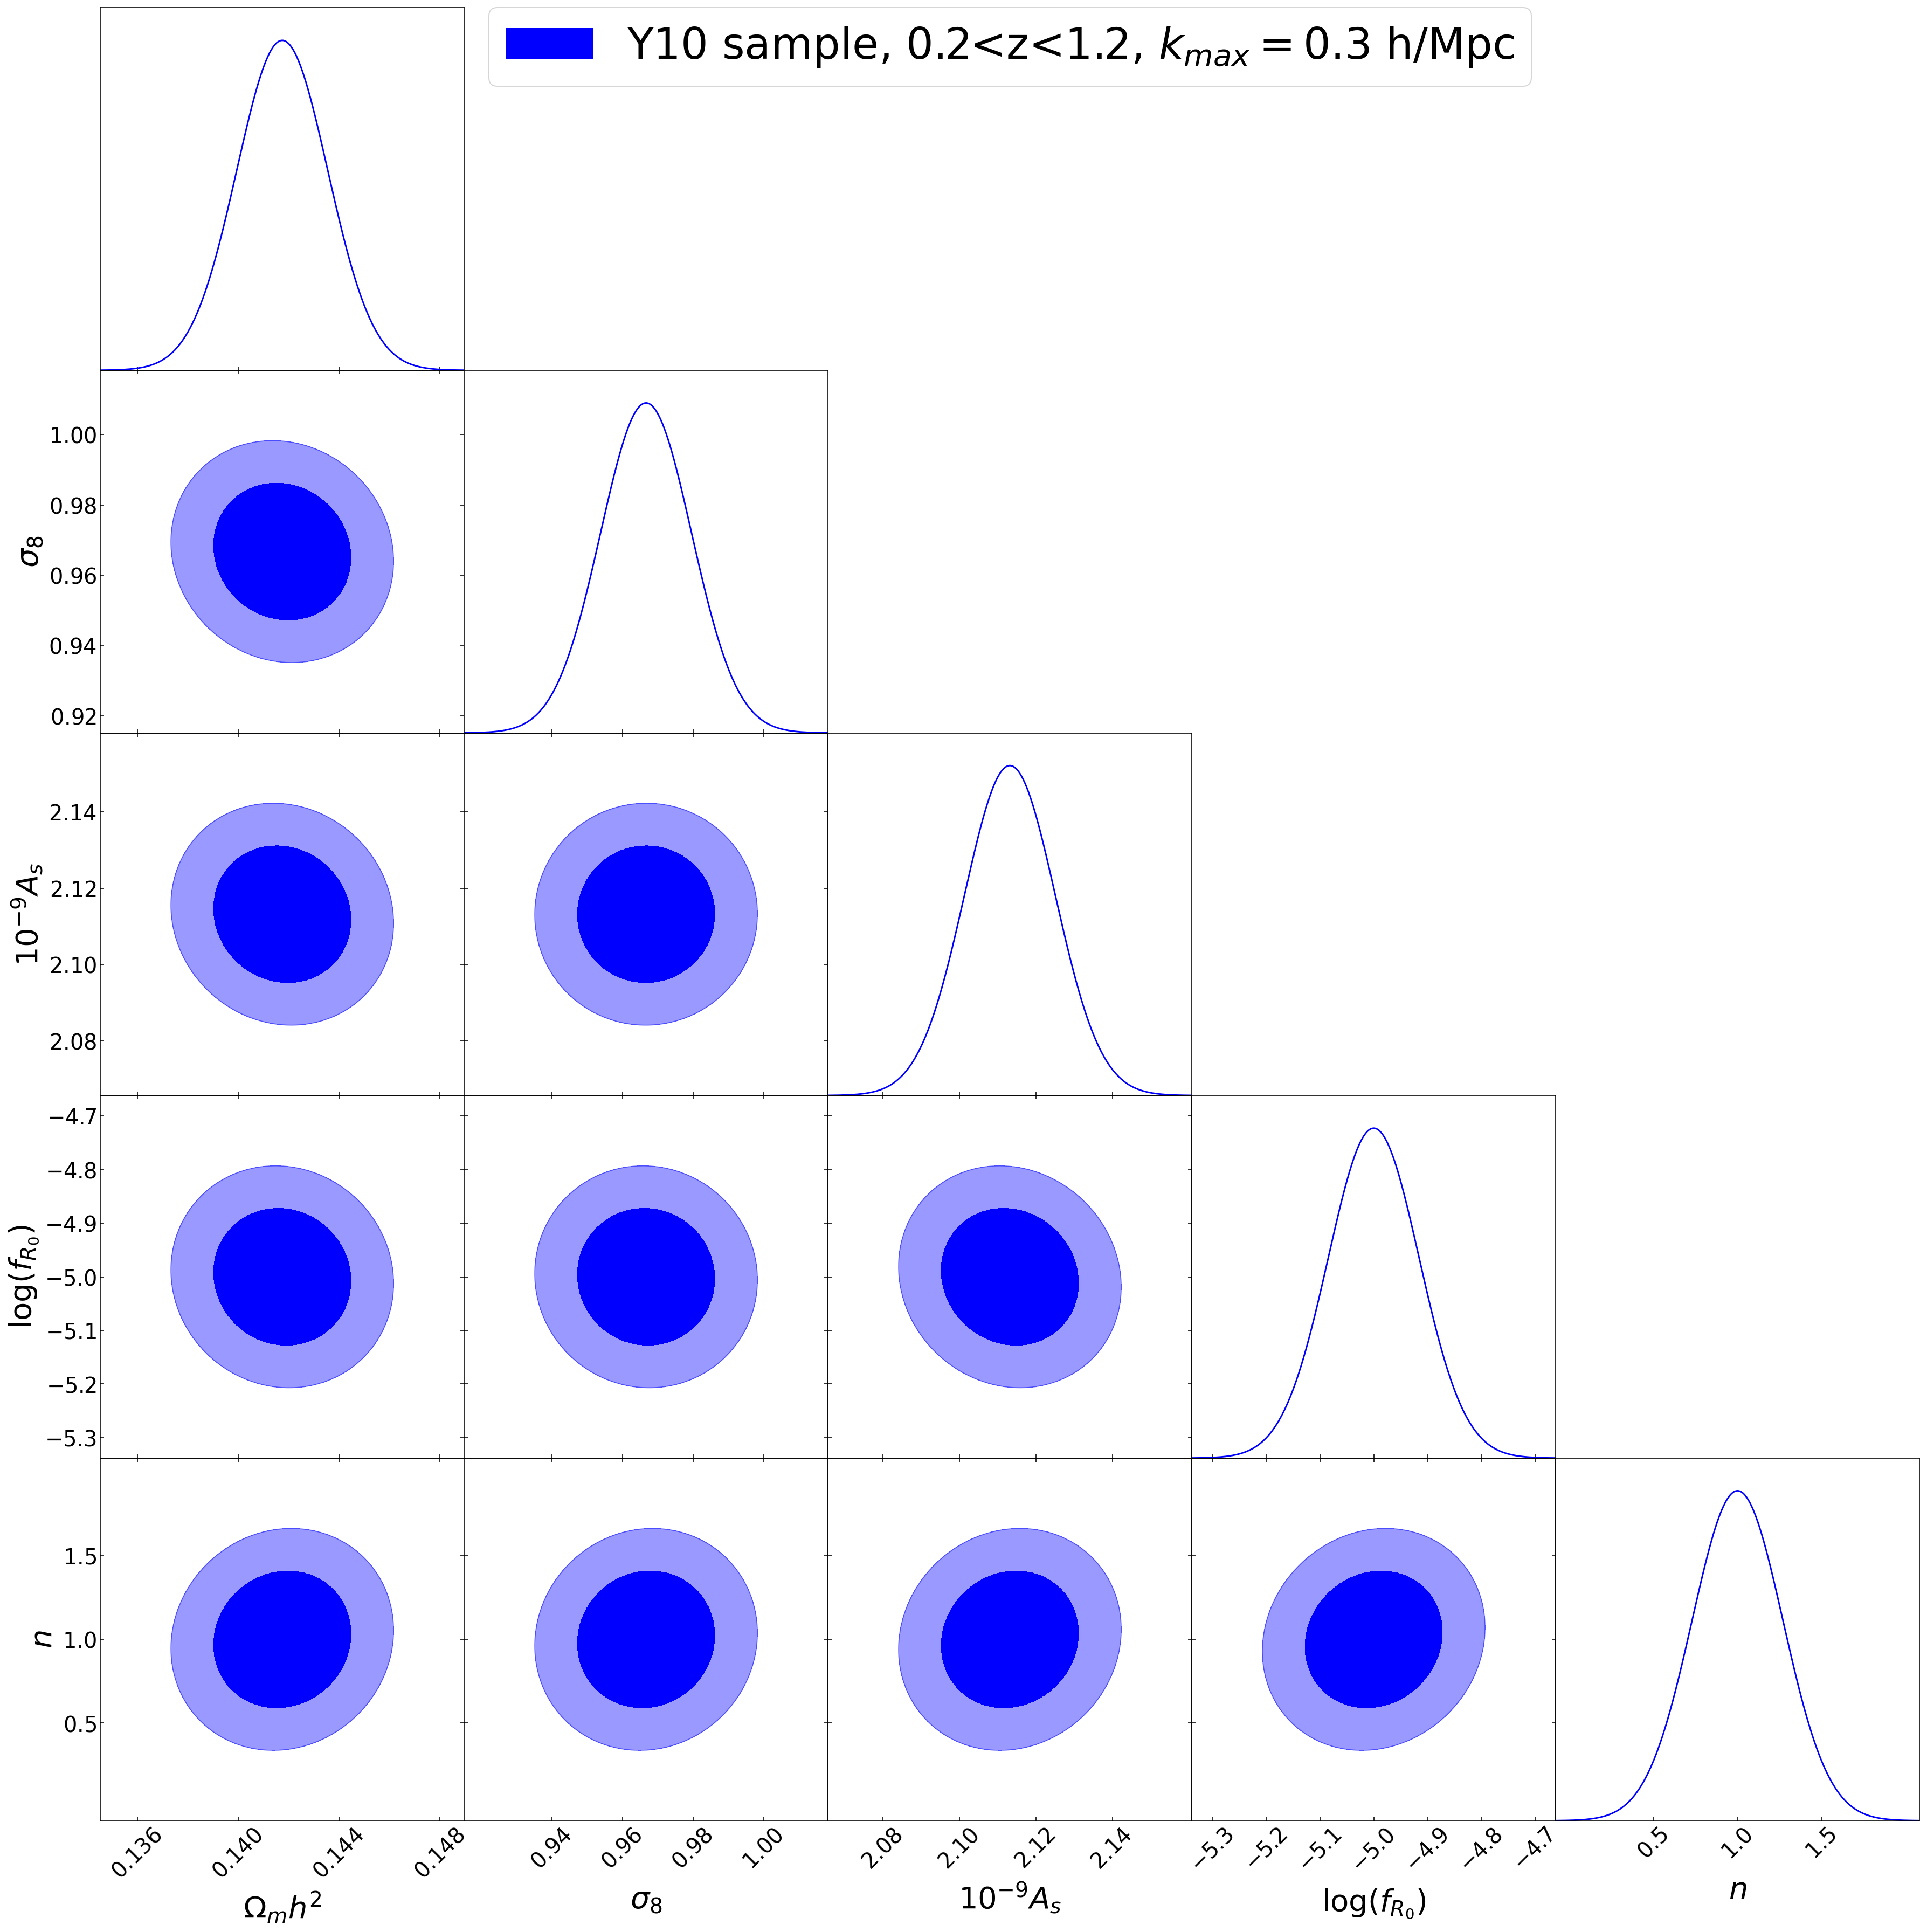

In [132]:
g = plots.get_subplot_plotter(subplot_size=5)
g.settings.legend_fontsize=40
g.settings.axes_fontsize=20
g.settings.axes_labelsize=28
g.settings.axis_tick_x_rotation=45

#i.triangle_plot([gaussPktest,gaussMktest,gausstest], names , filled=True, legend_labels=['P(k)','M(k)','WST'],contour_colors = ['Red', 'Green', 'Blue'])  
g.triangle_plot(gausstest, namessmall , filled=True, legend_labels=[r'Y10 sample, 0.2<z<1.2, $k_{max}=0.3$ h/Mpc'],contour_colors = ['Blue'])
#i.add_text(r'30 $\times$ $\rightarrow$',0.07, 0.6, ax=i.subplots[0,2], color='red', fontsize=10)









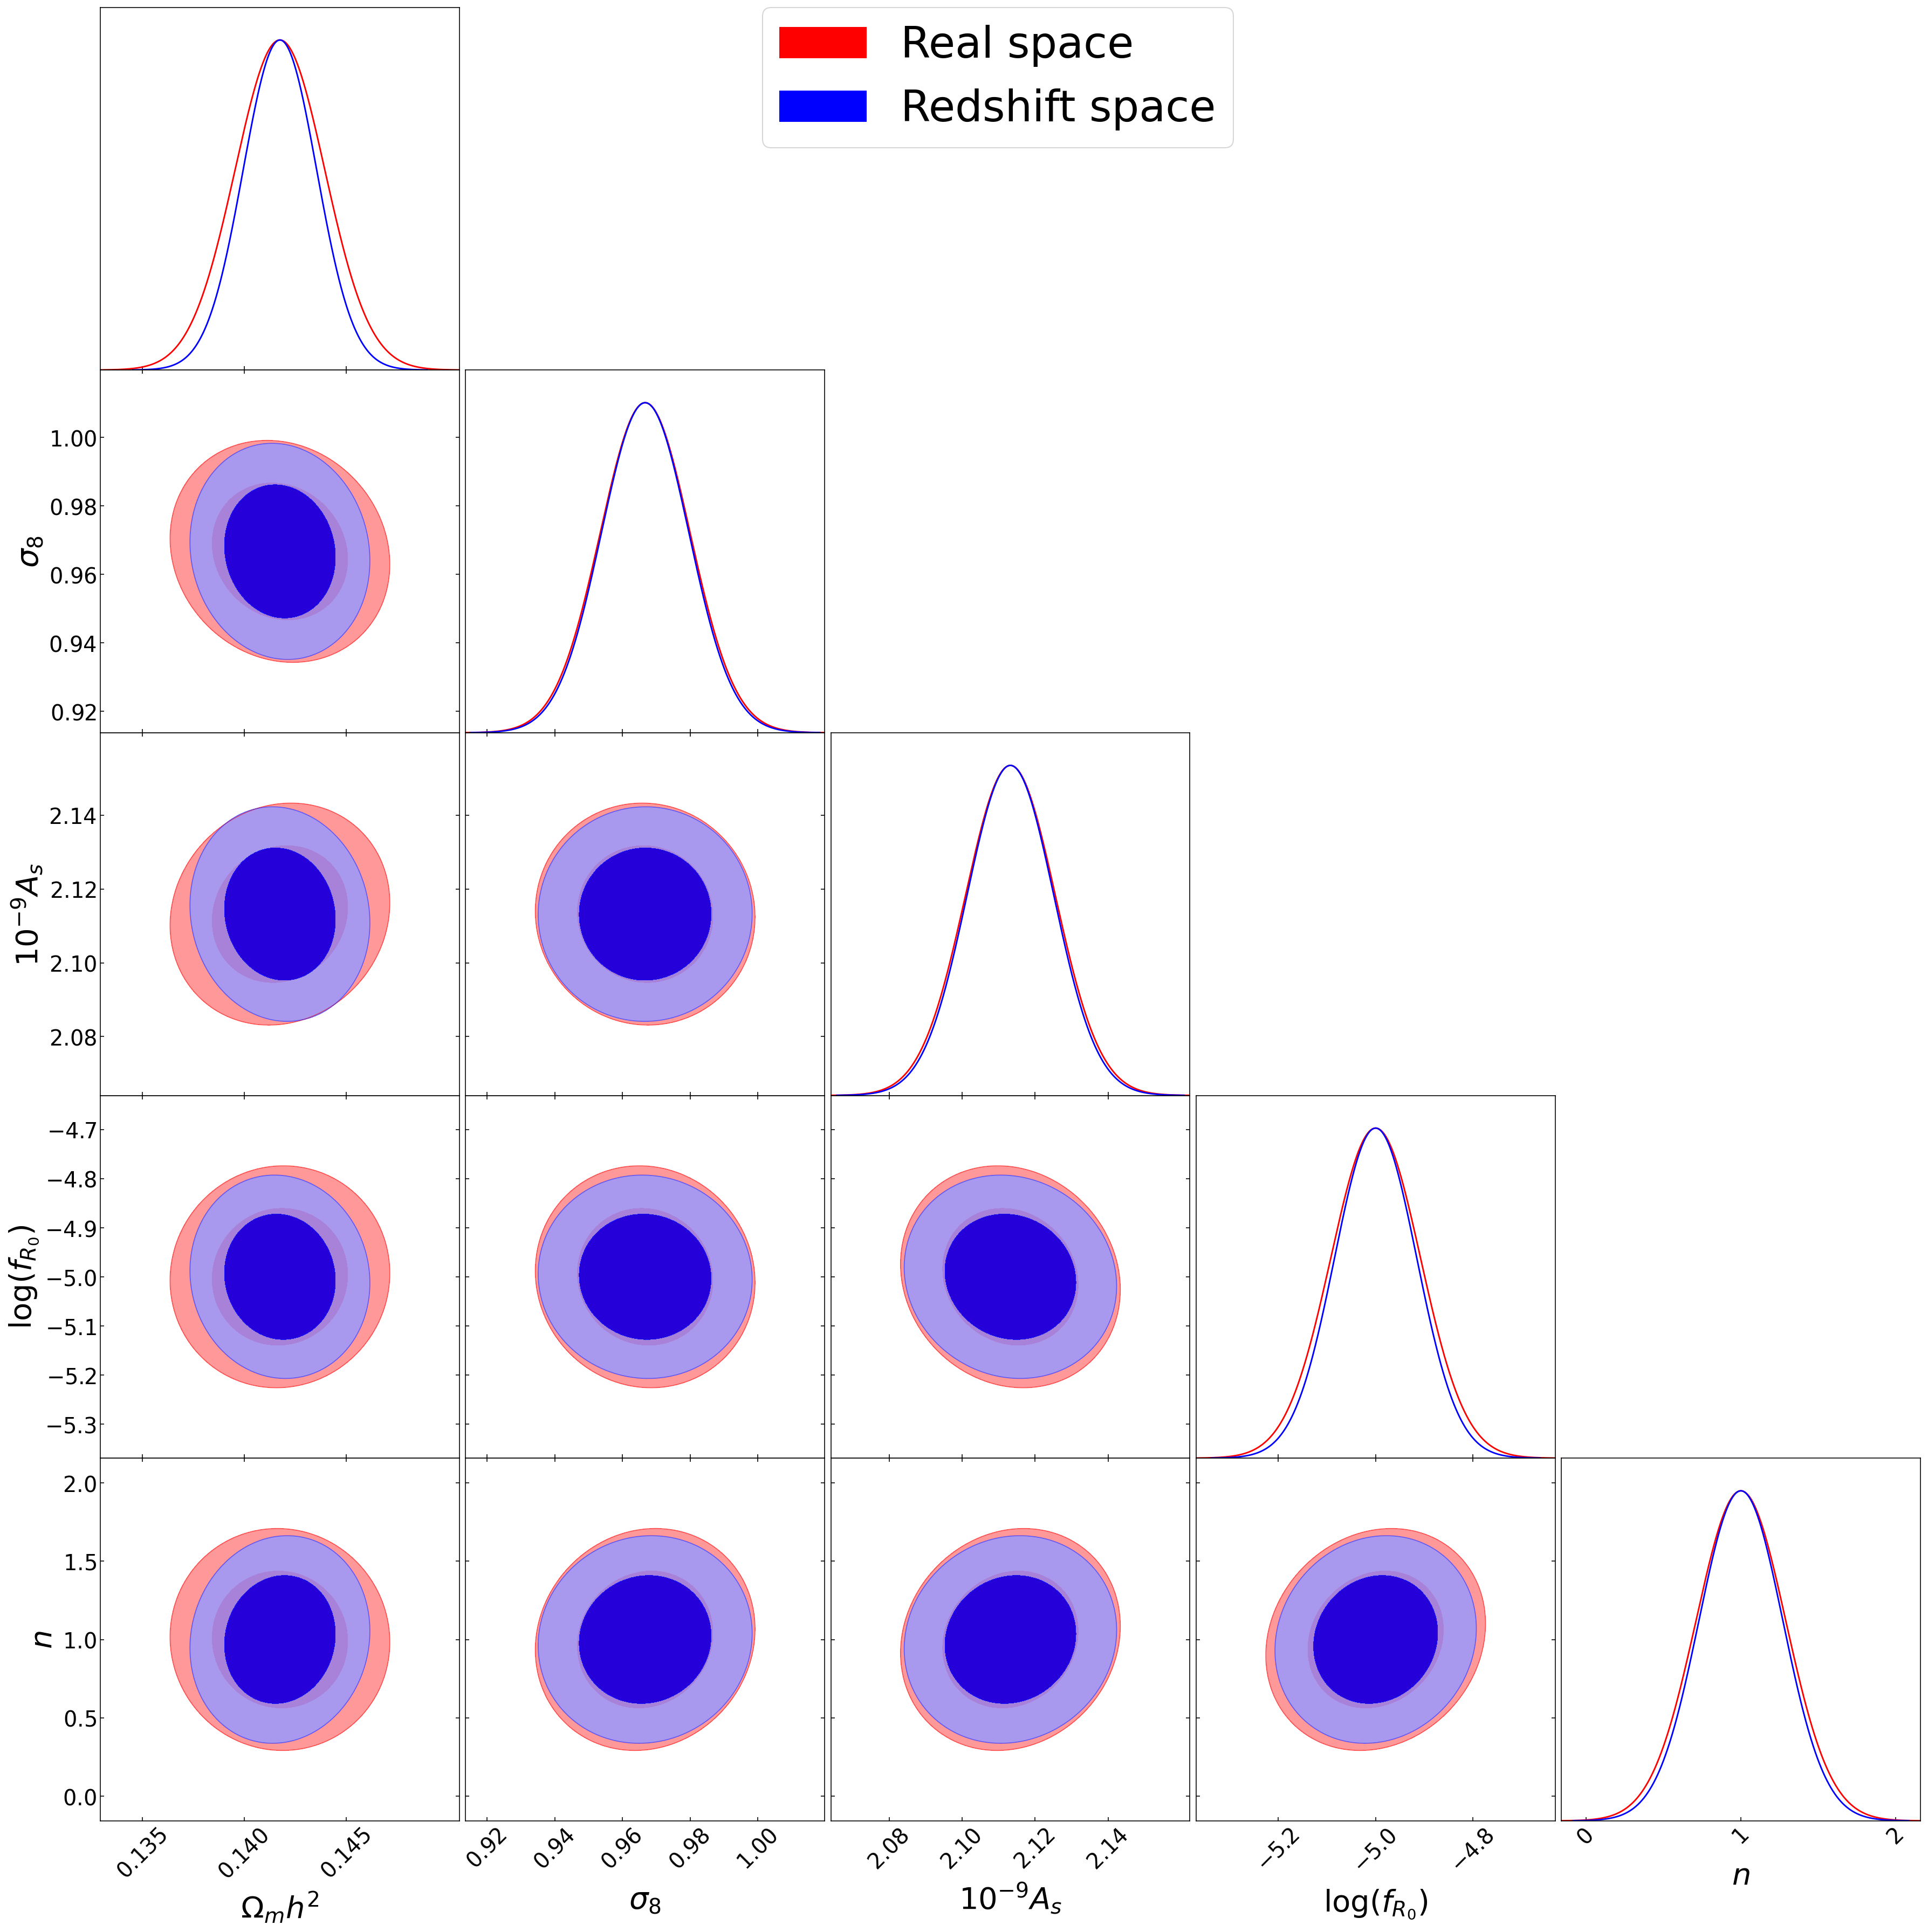

In [135]:
i = plots.get_subplot_plotter(subplot_size=5)
i.settings.legend_fontsize=40
i.settings.axes_fontsize=20
i.settings.axes_labelsize=28
i.settings.axis_tick_x_rotation=45

#i.triangle_plot([gaussPktest,gaussMktest,gausstest], names , filled=True, legend_labels=['P(k)','M(k)','WST'],contour_colors = ['Red', 'Green', 'Blue'])  
i.triangle_plot([gaussReal,gausstest], namessmall , filled=True, legend_labels=[r'Real space',r'Redshift space'],contour_colors = ['Red','Blue'])
#i.add_text(r'30 $\times$ $\rightarrow$',0.07, 0.6, ax=i.subplots[0,2], color='red', fontsize=10)









In [130]:
#import camb

In [86]:
np.sqrt(np.diag(np.linalg.inv(-FY10new)))

NameError: name 'FY10new' is not defined

In [48]:
np.sqrt(np.diag(np.linalg.inv(-FY10new)))

array([0.00249211, 0.01968897, 0.02471896, 0.27816877, 1.42677594,
       0.00780962])

In [45]:
#np.savetxt('./Covariance_data/FisherY10totk025As.txt', -FY10new)

In [50]:
#np.savetxt('./Covariance_data/FisherY10totk015As.txt', -FY10new)

In [54]:
np.savetxt('./Covariance_data/FisherY10totk05As.txt', -FY10new)

In [136]:
start = time.time()
elapsed_time_fl = (time.time() - start)
print (elapsed_time_fl) 

9.107589721679688e-05


In [ ]:
p_ggmg(0.34069262849522163, 0.6774, 0.9667, 0.8159, 1e-05, 1.0, 0.199904, 1.0553364364635174, 0)

In [32]:
import camb

#cp = camb.set_params(ns=0.96, H0=72, ombh2=0.0456*0.72*0.72, omch2=(0.26-0.0456)*0.72*0.72, w=-1.0, Alens=1.2, lmax=2000,
#                     WantTransfer=True)
#print (cp)
pars = camb.CAMBparams()
pars.WantTransfer = True
#print (pars)
Astemp = 2.689e-9
sig8 = 0.80
pars.set_cosmology(H0=72.0, ombh2=0.0456*0.72*0.72, omch2=(0.26-0.0456)*0.72*0.72)
pars.InitPower.set_params(ns=0.965, As=Astemp)
results = camb.get_results(pars)
print('Temporary sigma8=', results.get_sigma8())
Asnew = Astemp*(sig8/results.get_sigma8())**2
pars.InitPower.set_params(ns=0.965, As=Asnew)
results = camb.get_results(pars)
print('New sigma8=', results.get_sigma8())
print('New As=', Asnew)

from camb import get_matter_power_interpolator, model
PK = get_matter_power_interpolator(pars,nonlinear=False);
print('Power spectrum at z=0.5, k/h=0.1/Mpc is %s (Mpc/h)^3 '%(PK.P(0.5, 0.1)))

#print (PK.get_sigma8_0())



Temporary sigma8= [0.87534276]
New sigma8= [0.8]
New As= [2.24602452e-09]
Power spectrum at z=0.5, k/h=0.1/Mpc is 3306.840493192214 (Mpc/h)^3 


In [33]:
Asnew

array([2.24602452e-09])

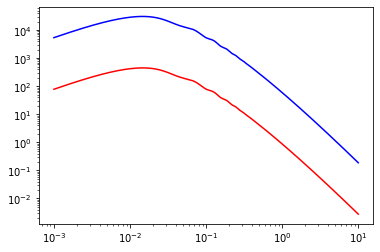

In [34]:
plt.figure('test Plin')
kk = np.logspace(-3,1,500)
plt.loglog(kk, PK.P(0.0, kk), color='b')
plt.loglog(kk, PK.P(99, kk), color='r')
plt.show()

In [ ]:
#np.savetxt('/Users/gev866/Downloads/plensz99.txt', (np.vstack((kk,PK.P(99, kk)))).T, fmt = '%1.8f')
np.savetxt('/Users/gev866/Downloads/plensz0.txt', (np.vstack((kk,PK.P(0.0, kk)))).T, fmt = '%1.8f')

In [35]:
#Camb Limber lensing
pars.set_for_lmax(5000, lens_potential_accuracy=1)
pars.Want_CMB = False
pars.NonLinear = model.NonLinear_both
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
pars.SourceWindows = [GaussianSourceWindow(redshift=1.0, source_type='lensing', sigma=0.001)]
results = camb.get_results(pars)
clslin = results.get_source_cls_dict()
ls=  np.arange(2, 5000+1)

In [36]:
pars.set_cosmology(H0=72.0, ombh2=0.0456*0.72*0.72, omch2=(0.638-0.0456)*0.72*0.72)
pars.InitPower.set_params(ns=0.965, As=Astemp)
resultsup = camb.get_results(pars)
print('Temporary sigma8=', resultsup.get_sigma8())
sig8 = 0.25
Asnew = Astemp*(sig8/resultsup.get_sigma8())**2
pars.InitPower.set_params(ns=0.965, As=Asnew)
resultsup = camb.get_results(pars)
print('New sigma8=', resultsup.get_sigma8())

Temporary sigma8= [1.50435714]
New sigma8= [0.25]


In [37]:
clsup = resultsup.get_source_cls_dict()

In [38]:
#cosmotr = pyccl.Cosmology(Omega_c=0.26-0.046, Omega_b=0.26-0.046, h=0.72, sigma8=0.8, n_s=0.96, transfer_function='bbks')
cosmotr = pyccl.Cosmology(Omega_c=0.26-0.0453, Omega_b=0.0453, h=0.72, sigma8=0.80, n_s=0.96, Neff=3.04, transfer_function='bbks', matter_power_spectrum='emu')
cosmofit = pyccl.Cosmology(Omega_c=0.26-0.0453, Omega_b=0.0453, h=0.72, sigma8=0.80, n_s=0.96, Neff=3.04, transfer_function='bbks', matter_power_spectrum='halofit')
import math
# Define a simple binned galaxy number density curve as a function of redshift
z_n = np.linspace(0.99, 1.01, 10)
n = np.ones(z_n.shape)
#z_n = np.array([1.0])
#n = np.ones(z_n.shape)

# Create objects to represent tracers of the weak lensing signal with this
# number density (with has_intrinsic_alignment=False)
lens1 = pyccl.WeakLensingTracer(cosmotr, dndz=(z_n, n))
lens2 = pyccl.WeakLensingTracer(cosmotr, dndz=(z_n, n))

# Calculate the angular cross-spectrum of the two tracers as a function of ell
#ell = np.arange(2, 5000)
ell = np.linspace(150, 5000, 50)
#ell = l
cls = pyccl.angular_cl(cosmotr, lens1, lens2, ell)

z_n = np.linspace(0.99, 1.01, 20)
n = np.ones(z_n.shape)
lens1f = pyccl.WeakLensingTracer(cosmofit, dndz=(z_n, n))
lens2f = pyccl.WeakLensingTracer(cosmofit, dndz=(z_n, n))
clsfit = pyccl.angular_cl(cosmofit, lens1f, lens2f, ell)
#print(cls)

In [39]:
rz = pyccl.background.angular_diameter_distance(cosmotr, 1.0/(1.0+1.0), a2=None)
#print (l,(l+0.2)/rz, rz)

In [40]:
ell*(ell+1)*cls

array([8.00239769e-05, 1.08774752e-04, 1.35276187e-04, 1.61624050e-04,
       1.88221472e-04, 2.14737837e-04, 2.40934130e-04, 2.66627289e-04,
       2.91677277e-04, 3.15988294e-04, 3.39488912e-04, 3.62126420e-04,
       3.83866609e-04, 4.04694725e-04, 4.24608790e-04, 4.43618120e-04,
       4.61741854e-04, 4.79003645e-04, 4.95430178e-04, 5.11050341e-04,
       5.25895637e-04, 5.39997621e-04, 5.53388909e-04, 5.66100448e-04,
       5.78163092e-04, 5.89607757e-04, 6.00465577e-04, 6.10764763e-04,
       6.20534121e-04, 6.29800325e-04, 6.38589407e-04, 6.46925168e-04,
       6.54834159e-04, 6.62338217e-04, 6.69458681e-04, 6.76216287e-04,
       6.82632224e-04, 6.88723072e-04, 6.94506846e-04, 7.00000045e-04,
       7.05219635e-04, 7.10180821e-04, 7.14897697e-04, 7.19383201e-04,
       7.23649589e-04, 7.27710461e-04, 7.31573837e-04, 7.35252292e-04,
       7.38755758e-04, 7.42094799e-04])

NameError: name 'l' is not defined

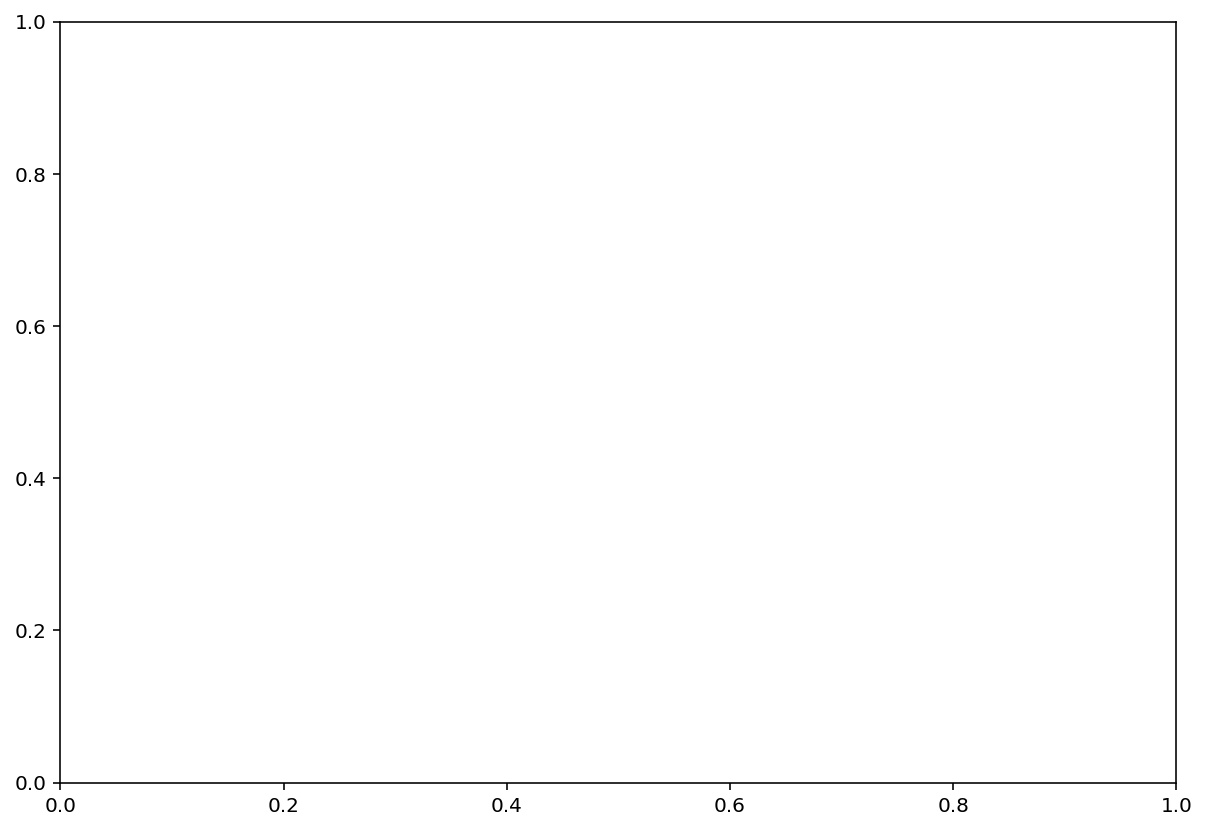

In [156]:
fig,ax = plt.subplots(figsize=(10, 7))
#ax.errorbar(l, Clavg10, yerr=0*Cerr10, label="440 realizations new", color='r')

ax.errorbar(l, ClavgG1800, label=r"Gadget seed 1", color='b')
#ax.fill_between(l,(ClavgG1800-CerrG1800), (ClavgG1800+CerrG1800), color='b', alpha=0.15)
ax.errorbar(l, ClavgG, label=r"Gadget seed 2", color='g')
ax.fill_between(l,(ClavgG-CerrG), (ClavgG+CerrG), color='g', alpha=0.15)
#ax.errorbar(l, Clavgold, label="512 Old COLA maps", color='g', linestyle='-.')
#ax.fill_between(l,Clavgold-Cerrold, Clavgold+Cerrold, color='g', alpha=0.15)
ax.errorbar(lzolt, ClZolt, label="Columbia", color='r')
ax.fill_between(lzolt,(ClZolt-CerrZolt), (ClZolt+CerrZolt), color='r', alpha=0.15)

ax.errorbar(lzolt, ClZoltseed2, label="Columbia seed 2", color='k')
#ax.errorbar(l, Cl10k, label="10000 COLA maps", color='g')
#ax.fill_between(l,Cl10k-Cerr10k, Cl10k+Cerr10k, color='g', alpha=0.15)
#ax.errorbar(l,Clavg10, yerr= 0*Cerr, label="Map avg", color='r')
#ax.fill_between(l,Clavg-2*Cerr, Clavg+2*Cerr, color='r', alpha=0.1)

#ax.errorbar(l, Clavg, label="COLA", color='c', linestyle = ':')
#ax.fill_between(l,(Clavg-Cerr), (Clavg+Cerr), color='c', alpha=0.1)
#ax.errorbar(ell, ell*(ell+1)*cls/(2*math.pi), label="Cosmic Emu", color='g')
#ax.errorbar(ell, ell*(ell+1)*clsfit/(2*math.pi), label="Halofit", color='g', linestyle='-.')
ax.errorbar(ls, clslin['W1xW1'][2:5000+1], label="CAMB Halofit", color='c', linestyle='-.')
plt.yticks(fontsize=17)
plt.rc('text', usetex=True)
plt.rc('font', size=17)
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.rc('axes',labelsize= 10)
#ax.set_xscale("linear")
#ax.set_yscale("linear")
#ax.set_xscale("log")
#ax.set_yscale("log")
plt.title('512 maps each')
ax.set_xlabel(r"$l$", fontsize=23)
ax.set_ylabel(r"$l(l+1)P_l/2\pi$", fontsize=23)
ax.legend(loc="best", fontsize=18, frameon=False)
#plt.xlim(150, 2000)
plt.tight_layout()
#plt.savefig('./Cl_compnew.png')
plt.show()

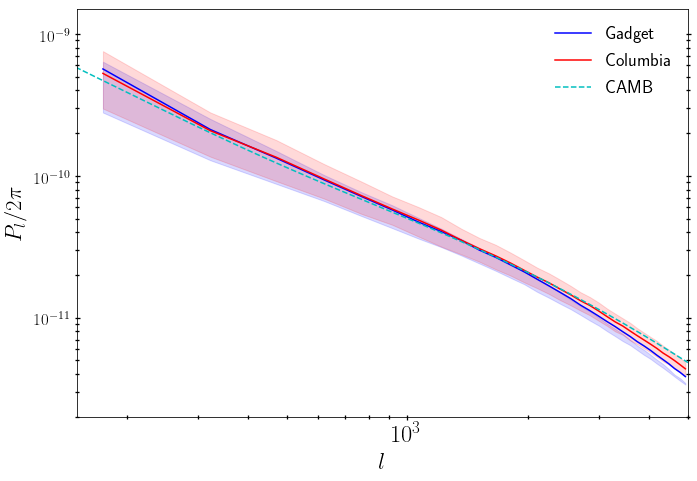

In [30]:
fig,ax = plt.subplots(figsize=(10, 7))
#ax.errorbar(l, Clavg10, yerr=0*Cerr10, label="440 realizations new", color='r')
ax.errorbar(l, ClavgG1800/l/(l+1), label="Gadget", color='b')
ax.fill_between(l,(ClavgG1800-CerrG1800)/l/(l+1), (Clavg+Cerr)/l/(l+1), color='b', alpha=0.15)

#ax.errorbar(l, Clavgold, label="512 Old COLA maps", color='g', linestyle='-.')
#ax.fill_between(l,Clavgold-Cerrold, Clavgold+Cerrold, color='g', alpha=0.15)
ax.errorbar(lzolt, ClZolt/l/(l+1), label="Columbia", color='r')
ax.fill_between(lzolt,(ClZolt-CerrZolt)/l/(l+1), (ClZolt+CerrZolt)/l/(l+1), color='r', alpha=0.15)
#ax.errorbar(l, Cl10k, label="10000 COLA maps", color='g')
#ax.fill_between(l,Cl10k-Cerr10k, Cl10k+Cerr10k, color='g', alpha=0.15)
#ax.errorbar(l,Clavg10, yerr= 0*Cerr, label="Map avg", color='r')
#ax.fill_between(l,Clavg-2*Cerr, Clavg+2*Cerr, color='r', alpha=0.1)
#ax.errorbar(ell, cls/(2*math.pi), label="Cosmic Emu", color='g')
#ax.errorbar(ell, clsfit/(2*math.pi), label="Halofit", color='c', linestyle='-.')
ax.errorbar(ls, clslin['W1xW1'][2:5000+1]/ls/(ls+1), label="CAMB", color='c', linestyle='--')
plt.yticks(fontsize=17)
plt.rc('text', usetex=True)
plt.rc('font', size=17)
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.rc('axes',labelsize= 10)
#ax.set_xscale("linear")
#ax.set_yscale("linear")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$l$", fontsize=23)
ax.set_ylabel(r"$P_l/2\pi$", fontsize=23)
ax.legend(loc="best", fontsize=18, frameon=False)
plt.xlim(150, 5000)
plt.ylim(2e-12, 1.5e-9)
plt.tick_params(axis='both',which='major',length=5, left='on', right='on', width=1, direction='inout')
plt.tick_params(axis='both',which='minor',length=3.2,left='on', right='on', width=1, direction='inout')
plt.tick_params(which='both',width=1.3)
plt.tight_layout()
plt.savefig('./Cl_complog.png')
plt.show()

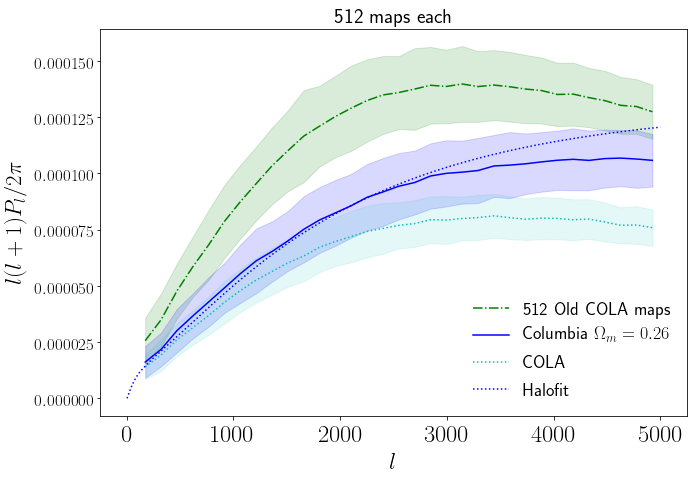

In [36]:
fig,ax = plt.subplots(figsize=(10, 7))
#ax.errorbar(l, Clavg10, yerr=0*Cerr10, label="440 realizations new", color='r')

#ax.errorbar(l, ClavgG1800, label=r"Gadget $1800^3$ grid", color='b')
#ax.fill_between(l,(ClavgG1800-CerrG1800), (ClavgG1800+CerrG1800), color='b', alpha=0.15)
#ax.errorbar(l, ClavgG, label=r"Gadget $512^3$ grid", color='g')
#ax.fill_between(l,(ClavgG-CerrG), (ClavgG+CerrG), color='m', alpha=0.15)
ax.errorbar(l, Clavgold, label="512 Old COLA maps", color='g', linestyle='-.')
ax.fill_between(l,Clavgold-Cerrold, Clavgold+Cerrold, color='g', alpha=0.15)
ax.errorbar(lzolt, ClZolt, label=r"Columbia $\Omega_m=0.26$", color='b')
ax.fill_between(lzolt,(ClZolt-CerrZolt), (ClZolt+CerrZolt), color='b', alpha=0.15)
#ax.errorbar(lzolt2, ClZolt2, label="Columbia", color='r')
#ax.fill_between(lzolt2,(ClZolt2-CerrZolt2), (ClZolt2+CerrZolt2), color='r', alpha=0.15)
#ax.errorbar(l, Cl10k, label="10000 COLA maps", color='g')
#ax.fill_between(l,Cl10k-Cerr10k, Cl10k+Cerr10k, color='g', alpha=0.15)
#ax.errorbar(l,Clavg10, yerr= 0*Cerr, label="Map avg", color='r')
#ax.fill_between(l,Clavg-2*Cerr, Clavg+2*Cerr, color='r', alpha=0.1)

ax.errorbar(l, Clavg, label="COLA", color='c', linestyle = ':')
ax.fill_between(l,(Clavg-Cerr), (Clavg+Cerr), color='c', alpha=0.1)
#ax.errorbar(ell, ell*(ell+1)*cls/(2*math.pi), label="Cosmic Emu", color='g')
#ax.errorbar(ell, ell*(ell+1)*clsfit/(2*math.pi), label="Halofit", color='g', linestyle='-.')
ax.errorbar(ls, clslin['W1xW1'][2:5000+1], label='Halofit', color='b', linestyle=':')
#ax.errorbar(ls, clsup['W1xW1'][2:5000+1], label=r"$\Omega_m=0.638$", color='r', linestyle='-.')
plt.yticks(fontsize=17)
plt.rc('text', usetex=True)
plt.rc('font', size=17)
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.rc('axes',labelsize= 10)
#ax.set_xscale("linear")
#ax.set_yscale("linear")
#ax.set_xscale("log")
#ax.set_yscale("log")
plt.title('512 maps each')
ax.set_xlabel(r"$l$", fontsize=23)
ax.set_ylabel(r"$l(l+1)P_l/2\pi$", fontsize=23)
ax.legend(loc="best", fontsize=18, frameon=False)
#plt.xlim(150, 2000)
#plt.ylim(1e-7, 4e-5)
plt.tight_layout()
#plt.savefig('./Cl_compnew.png')
plt.show()

In [152]:
h=0.72
#kemu, PkEmu = np.loadtxt('/Users/gev866/Downloads/CosmicEmu/P_tot/EMU0.txt', unpack=True)
from scipy.interpolate import interp1d
#Pfit = interp1d(kemu, PkEmu*h*h*h, kind='cubic')
#Pfit2 = interp1d(kemu*h, PkEmu, kind='cubic')
#kCOLA, PkCOLA = np.loadtxt('/Users/gev866/Downloads/Pkz0_COLA.txt', unpack=True)
#print (kCOLA/h,Pfit(kCOLA)/PkCOLA-1,Pfit(kCOLA)/PkCOLAh-1)

#kCOLAh, PkCOLAh = np.loadtxt('/Users/gev866/Downloads/Pkz0_COLA_100.txt', unpack=True)

#klin, Plinlens = np.loadtxt('/Users/gev866/Downloads/plinlens.txt', unpack=True)
#print (kCOLA/h,PkCOLAh/PkCOLA)

In [42]:
#PCOLAfit = interp1d(kCOLAh, PkCOLAh/h/h/h, kind='cubic')
count =0
aa=1
def Pfunc(k,a):
  pk_nl = pyccl.nonlin_matter_power(cosmofit, k, a)  
  #print (k)
  return np.asarray(pk_nl)    
  #return Pfit2(k)
#Pfunc = np.vectorize(Pfunc)
Pobj2D = pyccl.pk2d.Pk2D(pkfunc = Pfunc, cosmo = cosmotr)

In [43]:
#zvalues = np.loadtxt('/Users/gev866/Downloads/zvalues.txt')

In [44]:
zvalues[np.where(zvalues == 78.43282347242813)]

array([78.43282347])

In [ ]:
for i in range(zvalues.shape[0]-2,zvalues.shape[0]):
    zz = zvalues[i]
    print (zz)

In [181]:
# cosmo = pyccl.Cosmology(Omega_c= Om, Omega_b=0.0, h=h, n_s=ns, sigma8=s8, transfer_function='bbks')
cosmolens = pyccl.Cosmology(Omega_c=0.26-0.0453, Omega_b=0.0453, h=0.72, sigma8=0.80, n_s=0.96, Neff=3.04, transfer_function='boltzmann_class', matter_power_spectrum='emu')
#pyccl.comoving_radial_distance(cosmo, 1./(1+z))



In [41]:
zvalues = np.loadtxt('./zvalues.txt')

In [ ]:
aout = np.loadtxt('/Users/gev866/Downloads/outputs.txt')
zout = 1.0/aout - 1.0
#trc = pyccl.tracers.Tracer()
#tracer = pyccl.tracers.NumberCountsTracer(cosmolens, has_rsd=False, dndz=(zout, np.ones_like(zout)), bias=None, mag_bias=None)
#tracer1 = trc.add_tracer(cosmolens, kernel=None, transfer_ka=None, transfer_k=None, transfer_a=None, der_bessel=0, der_angles=0, is_logt=False, extrap_order_lok=0, extrap_order_hik=2)
#cllin = pyccl.cls.angular_cl(cosmolens, tracer, tracer, l, p_of_k_a=None, l_limber=-1, limber_integration_method='qag_quad')

In [46]:
pkratio , kemu = emu_fast(Omh2=Omh2, ns=ns, s8=s8, fR0=1e-5, n=1, z=0.4)

In [188]:
cosmolin = pyccl.Cosmology(Omega_c=0.26-0.0453, Omega_b=0.0453, h=0.72, sigma8=0.80, n_s=0.96, Neff=3.04, transfer_function='eisenstein_hu', matter_power_spectrum='linear')
pklin = pyccl.power.linear_matter_power(cosmolin, kemu, 1.0)
pklin *= h*h*h

In [299]:
zzz = np.linspace(0.06,32.0,600)
aaa = 1.0/(1.0+zzz)

In [300]:
afact = np.flip(aaa)

In [48]:
afact = np.linspace(0.02,1.0,100)

In [49]:
afact

array([0.02      , 0.02989899, 0.03979798, 0.04969697, 0.05959596,
       0.06949495, 0.07939394, 0.08929293, 0.09919192, 0.10909091,
       0.1189899 , 0.12888889, 0.13878788, 0.14868687, 0.15858586,
       0.16848485, 0.17838384, 0.18828283, 0.19818182, 0.20808081,
       0.2179798 , 0.22787879, 0.23777778, 0.24767677, 0.25757576,
       0.26747475, 0.27737374, 0.28727273, 0.29717172, 0.30707071,
       0.3169697 , 0.32686869, 0.33676768, 0.34666667, 0.35656566,
       0.36646465, 0.37636364, 0.38626263, 0.39616162, 0.40606061,
       0.4159596 , 0.42585859, 0.43575758, 0.44565657, 0.45555556,
       0.46545455, 0.47535354, 0.48525253, 0.49515152, 0.50505051,
       0.51494949, 0.52484848, 0.53474747, 0.54464646, 0.55454545,
       0.56444444, 0.57434343, 0.58424242, 0.59414141, 0.6040404 ,
       0.61393939, 0.62383838, 0.63373737, 0.64363636, 0.65353535,
       0.66343434, 0.67333333, 0.68323232, 0.69313131, 0.7030303 ,
       0.71292929, 0.72282828, 0.73272727, 0.74262626, 0.75252

In [337]:
#emu_fast(Omh2=Omh2, ns=ns, s8=s8, fR0=fr0, n=nn, z=1.0/afact[99]-1.0)

TypeError: 'GPR' object is not iterable

In [52]:
nn=1

In [53]:
import gc

In [54]:
for i in range(afact.shape[0]-3):
   #print (i, afact[i]) 
   
   pkratio , k = emu_fast(Omh2=Omh2, ns=ns, s8=s8, fR0=fr0, n=nn, z=1.0/afact[i]-1.0)
   kccl = k*h
   pk_nl = pyccl.nonlin_matter_power(cosmofit, kccl, afact[i])
   gc.collect() 
   if (i==0):
      Pkmat =  pk_nl*pkratio
   else:
      Pkmat = np.vstack((Pkmat,pk_nl*pkratio))

In [305]:
Pkmatflat = Pkmat.flatten()

In [339]:
Pkmat.shape

(97, 213)

In [313]:
Pkmat[:,1] = np.flip(Pkmat[:,1] )

In [69]:
pbj2Dtest = pyccl.pk2d.Pk2D(a_arr=afact[:97], lk_arr=np.log(kccl), pk_arr=Pkmat, cosmo = cosmotr, extrap_order_lok=1, extrap_order_hik=1, is_logp=False)    










In [70]:
clsMGF5fast = pyccl.angular_cl(cosmofit, lens1f, lens2f, ell, p_of_k_a=pbj2Dtest)

In [71]:
ell*(ell+1)*(clsMGF5fast)/(math.pi)/2.0

array([ 1.39028703e-05,  1.90315952e-05,  2.37959949e-05,  2.84516563e-05,
        3.29167498e-05,  3.70754904e-05,  4.08393411e-05,  4.41443285e-05,
        4.69410438e-05,  4.91798837e-05,  5.08150627e-05,  5.17893010e-05,
        5.20509448e-05,  5.15492768e-05,  5.02380285e-05,  4.80821179e-05,
        4.50493457e-05,  4.11163345e-05,  3.62614525e-05,  3.04638790e-05,
        2.37022271e-05,  1.59854291e-05,  7.32100821e-06, -2.36309170e-06,
       -1.30917259e-05, -2.48894967e-05, -3.77830230e-05, -5.17965012e-05,
       -6.69579519e-05, -8.32886104e-05, -1.00815077e-04, -1.19559028e-04,
       -1.39542764e-04, -1.60788538e-04, -1.83316944e-04, -2.07146713e-04,
       -2.32297949e-04, -2.58789222e-04, -2.86639853e-04, -3.15866891e-04,
       -3.46486739e-04, -3.78518220e-04, -4.11976950e-04, -4.46879738e-04,
       -4.83241630e-04, -5.21075561e-04, -5.60407738e-04, -6.01241354e-04,
       -6.43594191e-04, -6.87480648e-04])

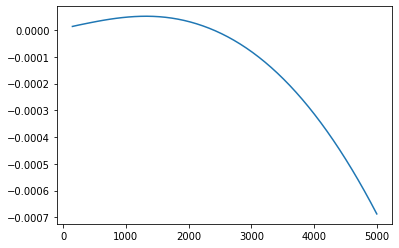

In [72]:
plt.plot(ell,ell*(ell+1)*(clsMGF5fast)/(math.pi)/2.0)

In [ ]:
#(pkfunc=None, a_arr=None, lk_arr=None, pk_arr=None, is_logp=True, extrap_order_lok=1, extrap_order_hik=2, cosmo=None, empty=False)

In [73]:
#pmg(Om, h, ns, s8, fR0, n, z)
def PfuncMGfast(k,a): 
  z=1.0/a-1.0
  #print (1.0/a-1.0)    
  pk_nl = pyccl.nonlin_matter_power(cosmofit, k, a) 
  if (z>31.99 or k/h<kemu[0] or z==0.01):
    return np.asarray(pk_nl)
  elif (k/h>kemu[-1]):
    ind = np.where(zvalues == z)    
    pkratio , kk = emu_fast(Omh2=Omh2, ns=ns, s8=s8, fR0=1e-5, n=1, z=z)
    gc.collect() 
    #pkratio = PMGdat[ind,:]        
    ratiomgfit = interp1d(kk*h, pkratio, kind='cubic', fill_value="extrapolate")
    return np.asarray(pk_nl*ratiomgfit(k))
  else:
    ind = np.where(zvalues == z)    
    pkratio , kk = emu_fast(Omh2=Omh2, ns=ns, s8=s8, fR0=1e-5, n=1, z=z)
    gc.collect() 
    #pkratio = PMGdat[ind,:]
    ratiomgfit = interp1d(kk*h, pkratio, kind='cubic')
    return np.asarray(pk_nl*ratiomgfit(k))
PfuncMGfast = np.vectorize(PfuncMGfast) 

In [74]:
ell

array([ 150.        ,  248.97959184,  347.95918367,  446.93877551,
        545.91836735,  644.89795918,  743.87755102,  842.85714286,
        941.83673469, 1040.81632653, 1139.79591837, 1238.7755102 ,
       1337.75510204, 1436.73469388, 1535.71428571, 1634.69387755,
       1733.67346939, 1832.65306122, 1931.63265306, 2030.6122449 ,
       2129.59183673, 2228.57142857, 2327.55102041, 2426.53061224,
       2525.51020408, 2624.48979592, 2723.46938776, 2822.44897959,
       2921.42857143, 3020.40816327, 3119.3877551 , 3218.36734694,
       3317.34693878, 3416.32653061, 3515.30612245, 3614.28571429,
       3713.26530612, 3812.24489796, 3911.2244898 , 4010.20408163,
       4109.18367347, 4208.16326531, 4307.14285714, 4406.12244898,
       4505.10204082, 4604.08163265, 4703.06122449, 4802.04081633,
       4901.02040816, 5000.        ])

In [ ]:
start = time.time()
Pobj2DMGfast = pyccl.pk2d.Pk2D(pkfunc = PfuncMGfast, cosmo = cosmotr, is_logp=False)
clsMGF5fast = pyccl.angular_cl(cosmotr, lens1f, lens2f, ell, p_of_k_a=Pobj2DMGfast)
elapsed_time_fl = (time.time() - start)
print (elapsed_time_fl) 

In [174]:
cls3dtest = pyccl.angular_cl(cosmotr, lens1f, lens2f, ell, p_of_k_a=Pobj2D)

CCLError: Error CCL_ERROR_INTEG: ccl_cls.c: ccl_angular_cls_limber(); integration error


In [186]:
ell

array([ 150.        ,  248.97959184,  347.95918367,  446.93877551,
        545.91836735,  644.89795918,  743.87755102,  842.85714286,
        941.83673469, 1040.81632653, 1139.79591837, 1238.7755102 ,
       1337.75510204, 1436.73469388, 1535.71428571, 1634.69387755,
       1733.67346939, 1832.65306122, 1931.63265306, 2030.6122449 ,
       2129.59183673, 2228.57142857, 2327.55102041, 2426.53061224,
       2525.51020408, 2624.48979592, 2723.46938776, 2822.44897959,
       2921.42857143, 3020.40816327, 3119.3877551 , 3218.36734694,
       3317.34693878, 3416.32653061, 3515.30612245, 3614.28571429,
       3713.26530612, 3812.24489796, 3911.2244898 , 4010.20408163,
       4109.18367347, 4208.16326531, 4307.14285714, 4406.12244898,
       4505.10204082, 4604.08163265, 4703.06122449, 4802.04081633,
       4901.02040816, 5000.        ])

In [187]:
plt.plot(ell, ell*(ell+1)*cls)

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode

(/n/home02/gvalogiannis/.cache/matplotlib/tex.cache/e3e438fe95fc4f12b6c4ec16c91
02a0a.tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for english, dumylang, nohyphenation, lo
aded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.5 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on e3e438fe95fc4f12b6c4ec16c9102a0a.log.




<Figure size 432x288 with 1 Axes>

In [65]:
ell*(ell+1)*clsMGF5fast

array([ 8.73543104e-05,  1.19579039e-04,  1.49514646e-04,  1.78767029e-04,
        2.06822038e-04,  2.32952177e-04,  2.56601148e-04,  2.77366996e-04,
        2.94939277e-04,  3.09006323e-04,  3.19280456e-04,  3.25401775e-04,
        3.27045731e-04,  3.23893658e-04,  3.15654842e-04,  3.02108857e-04,
        2.83053387e-04,  2.58341549e-04,  2.27837426e-04,  1.91410197e-04,
        1.48925485e-04,  1.00439413e-04,  4.59992512e-05, -1.48477430e-05,
       -8.22577400e-05, -1.56385320e-04, -2.37397735e-04, -3.25447016e-04,
       -4.20709220e-04, -5.23317773e-04, -6.33439809e-04, -7.51211528e-04,
       -8.76773047e-04, -1.01026418e-03, -1.15181433e-03, -1.30154118e-03,
       -1.45957106e-03, -1.62602063e-03, -1.80101131e-03, -1.98465021e-03,
       -2.17704039e-03, -2.37830012e-03, -2.58852752e-03, -2.80782821e-03,
       -3.03629671e-03, -3.27401431e-03, -3.52114567e-03, -3.77771084e-03,
       -4.04382157e-03, -4.31956831e-03])

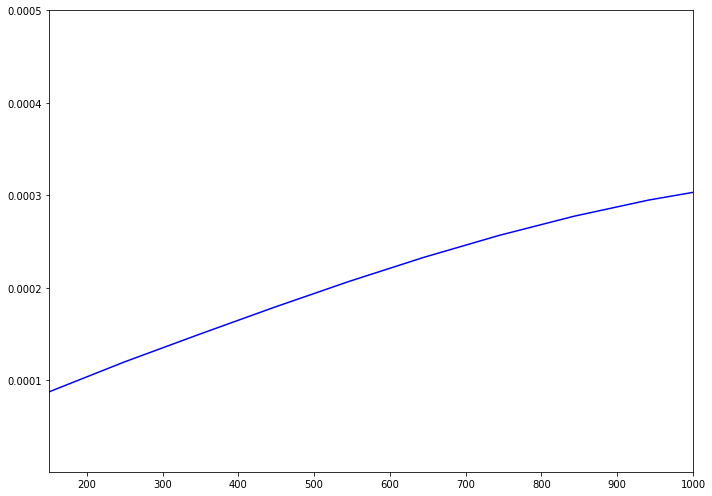

In [68]:
fig,ax = plt.subplots(figsize=(10, 7))
#ax.errorbar(l, Clavg10, yerr=0*Cerr10, label="440 realizations new", color='r')

ax.errorbar(ell, ell*(ell+1)*clsMGF5fast, color='b')
#ax.fill_between(l,(ClavgG1800-CerrG1800), (ClavgG1800+CerrG1800), color='b', alpha=0.15)
#ax.errorbar(l, ClavgG, label=r"Gadget seed 2", color='g')

#ax.errorbar(l, Clavgold, label="512 Old COLA maps", color='g', linestyle='-.')
#ax.fill_between(l,Clavgold-Cerrold, Clavgold+Cerrold, color='g', alpha=0.15)
#ax.errorbar(lzolt, ClZolt, label="Columbia", color='r')
#ax.fill_between(lzolt,(ClZolt-CerrZolt), (ClZolt+CerrZolt), color='r', alpha=0.15)

#ax.errorbar(lzolt, ClZoltseed2, label="Columbia seed 2", color='k')
#ax.errorbar(l, Cl10k, label="10000 COLA maps", color='g')
#ax.fill_between(l,Cl10k-Cerr10k, Cl10k+Cerr10k, color='g', alpha=0.15)
#ax.errorbar(l,Clavg10, yerr= 0*Cerr, label="Map avg", color='r')
#ax.fill_between(l,Clavg-2*Cerr, Clavg+2*Cerr, color='r', alpha=0.1)

#ax.errorbar(l, Clavg, label="COLA", color='c', linestyle = ':')
#ax.fill_between(l,(Clavg-Cerr), (Clavg+Cerr), color='c', alpha=0.1)
#ax.errorbar(ell, ell*(ell+1)*cls/(2*math.pi), label="Cosmic Emu", color='g')
#ax.errorbar(ell, ell*(ell+1)*clsfit/(2*math.pi), label="Halofit", color='g', linestyle='-.')

#ax.set_xscale("linear")
#ax.set_yscale("linear")
#ax.set_xscale("log")
#ax.set_yscale("log")
#plt.title('512 maps each')
#ax.set_xlabel(r"$l$", fontsize=23)
#ax.set_ylabel(r"$l(l+1)P_l/2\pi$", fontsize=23)
ax.legend(loc="best", fontsize=18, frameon=False)
plt.xlim(ell[0], 1000)
plt.ylim(1e-6, 5e-4)
plt.tight_layout()
#plt.savefig('./Cl_compnew.png')
plt.show()

In [170]:
from matplotlib import gridspec
from matplotlib import cm
def applyPlotStylePk():
 plt.tick_params(axis='both',which='major',length=5, left='on', right='on', width=1, direction='inout')
 plt.tick_params(axis='both',which='minor',length=3.2,left='on', right='on', width=1, direction='inout')
 plt.tick_params(which='both',width=1.3)
 #plt.grid(True)
 plt.xscale("log")
 #plt.yscale("log")
 plt.xlim(0.1, 3.60)
 plt.ylim(0, 700)
 #plt.ylim(11, 50000)
 #plt.ylabel(r"$\frac{P_{MG}}{P_{\Lambda CDM}}$",fontsize=18)
 ax.set_xlabel(r"$k (h/Mpc)$", fontsize=23)
 ax.set_ylabel(r"$k P(k)$", fontsize=23)
 #plt.ylabel(r"$r (Mpc/h)$",fontsize=18)
 plt.legend(loc="best", frameon=False, numpoints=1, prop={'size':12})
def applyPlotStylesub():
 plt.tick_params(axis='both',which='major',length=5, left='on', right='on', width=1, direction='inout')
 plt.tick_params(axis='both',which='minor',length=3.2,left='on', right='on', width=1, direction='inout')
 plt.tick_params(which='both',width=1.3)
 #plt.grid(True)
 plt.xscale("log")
 #plt.yscale("log")
 plt.xlim(0.1, 3.60)
 #plt.ylim(0, 700)
 plt.ylabel(r"$\frac{P_{COLA}}{P_{Emu}}-1$",fontsize=24)
 ax2.set_xlabel(r"$k (h/Mpc)$", fontsize=23)
 #ax2.set_ylabel(r"$P(k)$", fontsize=23)
 plt.xlabel(r"$k (h/Mpc)$",fontsize=23)
 plt.legend(loc="best", frameon=False, numpoints=1, prop={'size':12})

gs=gridspec.GridSpec(2,1, wspace=0.0, hspace=0.0, height_ratios=[5,4])
fig10=plt.figure('Pkcomp', figsize=(0.95*9, 0.94*11))
ax=fig10.add_subplot(gs[0,0])
applyPlotStylePk()
ax2=fig10.add_subplot(gs[1,0])
applyPlotStylesub()
ax.set_title(r' Comparison at $z=0.0$')
ax.errorbar(kemu/h, (kemu/h)*PkEmu*h*h*h, color='b',label='CosmicEmu')#, markersize='4'
#ax.errorbar(kCOLA/h, kCOLA/h*pk_lens, color='b',label='CosmicEmu')#,label='CosmicEmu')
ax.errorbar(kCOLA/h, (kCOLA/h)*PkCOLA, color='g', label='COLA 40 steps')
ax.errorbar(kCOLA/h, (kCOLA/h)*PkCOLAh, color='r', label='COLA 100 steps', linestyle='-.')
#ax.errorbar(kemu/h, (kemu/h)*pklin, color='c', linestyle=':',label='Linear')
#ax.errorbar(klin, klin*Plinlens, color='c', linestyle=':',label='CAMB')
ax.errorbar(klin, klin*PK.P(0.0,klin), color='c', linestyle=':',label='CAMB')
ax.legend(loc="best", frameon=False, numpoints=1, prop={'size':16})
plt.setp(ax.get_xticklabels(), visible=False)
ax2.errorbar(kCOLA/h, PkCOLA/pk_lens-1, color='g')
ax2.errorbar(kCOLA/h, PkCOLAh/pk_lens-1, color='r', linestyle='-.')
#ax.errorbar(kRSD, Pk0RSD, color='r', marker = '^', markersize='4', linestyle='-.', label='Redshift space')
plt.legend(loc="best", frameon=False, numpoints=1, prop={'size':16})
plt.tight_layout()
plt.show()
#plt.savefig('./Pk_compnew.png')

NameError: name 'kemu' is not defined

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode

(/n/home02/gvalogiannis/.cache/matplotlib/tex.cache/b7d28c1729ec61988e5b1f07d8d
009fd.tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for english, dumylang, nohyphenation, lo
aded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.5 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on b7d28c1729ec61988e5b1f07d8d009fd.log.




<Figure size 615.6x744.48 with 2 Axes>

In [ ]:
np.logspace(math.log(45,10), math.log(5000,10), 34)

In [ ]:
testlike = np.load('/Users/gev866/Downloads/arrays/epoch75_predvalloglike.npy')

In [ ]:
mvn = np.load('/Users/gev866/Downloads/arrays/mvn_val_loglike.npy')

In [ ]:
testlike[:,0].shape

In [ ]:
fig1 = plt.figure('testlike', figsize=(11, 8))
ax = fig1.add_subplot(111)
#ax.plot(Plmat[:,10], mvn_loglike, linestyle='None', marker='o')
#for i in range(Plmat.shape[1]):
#for i in range(9,10):    
#  ax.plot(Plmat[:,i]-Clavgfid[i], logvec[:,i]) 
#ax.set_xscale("log")
#ax.set_yscale("log")    
#ax.errorbar(l, mvn_loglike)
#ax.scatter(np.arange(testlike.shape[0]), testlike/(np.amin(testlike)))
#ax.scatter(np.arange(mvn.shape[0]), mvn/(np.amin(testlike)))
#ax.scatter(np.arange(testlike.shape[0]), testlike/(np.amin(testlike)))
ax.plot(np.arange(mvn.shape[0]), -mvn+testlike[:,0], linestyle='None', marker='o')
plt.show()